# Adaptive Filter for Acoustic Signal Segmentation

In modern signal processing, the application of gradient-based optimization techniques has opened up novel avenues for solving complex problems. In this work, we introduce a segmentation algorithm based on an **adaptive filter**. This filter is designed to segment an acoustic signal into two predominant melting regimes, namely:
- **Conduction**
- **Keyhole**

These regimes are essential in understanding the acoustic behavior and optimizing the process parameters in applications such as welding and metal 3D printing.

### Initialization of Filter Taps

A crucial aspect of adaptive filters is the initialization of filter taps. In our approach, the filter taps of the adaptive filter are initialized using the Finite Impulse Response (FIR) window method, leveraging the `scipy.signal.firwin` function. This method designs a linear-phase FIR filter and returns the filter coefficients, which then serve as the initial weights (or taps) for our adaptive filter.

By utilizing a gradient-based optimization framework, our adaptive filter can learn and adapt its weights based on the input data, making it particularly effective in environments where the signal characteristics may change over time. This flexibility allows our filter to achieve high precision in segmenting the acoustic signal into its respective melting regimes.

In the following sections, we will delve deeper into the implementation details, training process, and results visualization.


In [1]:
import random
import torch
import numpy as np
import pandas as pd
import scipy.signal
import seaborn as sns
from torch import nn, optim
import matplotlib.pyplot as plt
from torchmetrics import F1Score
from torch.nn import functional as F
from torchmetrics import Precision, Recall
from sklearn.metrics import confusion_matrix

# Set the limit for the number of open figures before issuing a warning
plt.rcParams['figure.max_open_warning'] = 50

### Setting up Reproducibility and Initial Parameters
Reproducibility is crucial in scientific experiments. We set a fixed random seed to ensure that our results are consistent across multiple runs.

In [2]:
# Setting a seed for reproducibility
seed = 1995
random.seed(seed)     # Seed for Python's random module
np.random.seed(seed)  # Seed for NumPy random functions
torch.manual_seed(seed)  # Seed for PyTorch
torch.cuda.manual_seed_all(seed)  # Seed for PyTorch on GPU


### Defining Constants
Next, we define some constants for our adaptive filter.

In [3]:
# Number of iterations for training
n_iters = 50
# Sampling frequency of the signal
Fs = 2000000
# Size (number of taps) of the filter
size = 2501


### Setting Up Visualization in Jupyter Notebook
To visualize our results in the Jupyter notebook, we activate the inline plotting mode for matplotlib.

In [4]:
%matplotlib notebook

### Initializing Filter Taps
Here, we initialize the taps (or weights) of our adaptive filter using the FIR window method.

In [5]:
# Define frequency values normalized by Nyquist rate (Fs/2)
f1 = (35000*2)/Fs
f2 = (105000*2)/Fs

# Initialize the filter weights using the FIR window method
weigths_init = scipy.signal.firwin(size, [f1, f2], pass_zero=False)


### Visualizing Initial Filter Taps
Let's visualize the initialized filter taps.

<IPython.core.display.Javascript object>


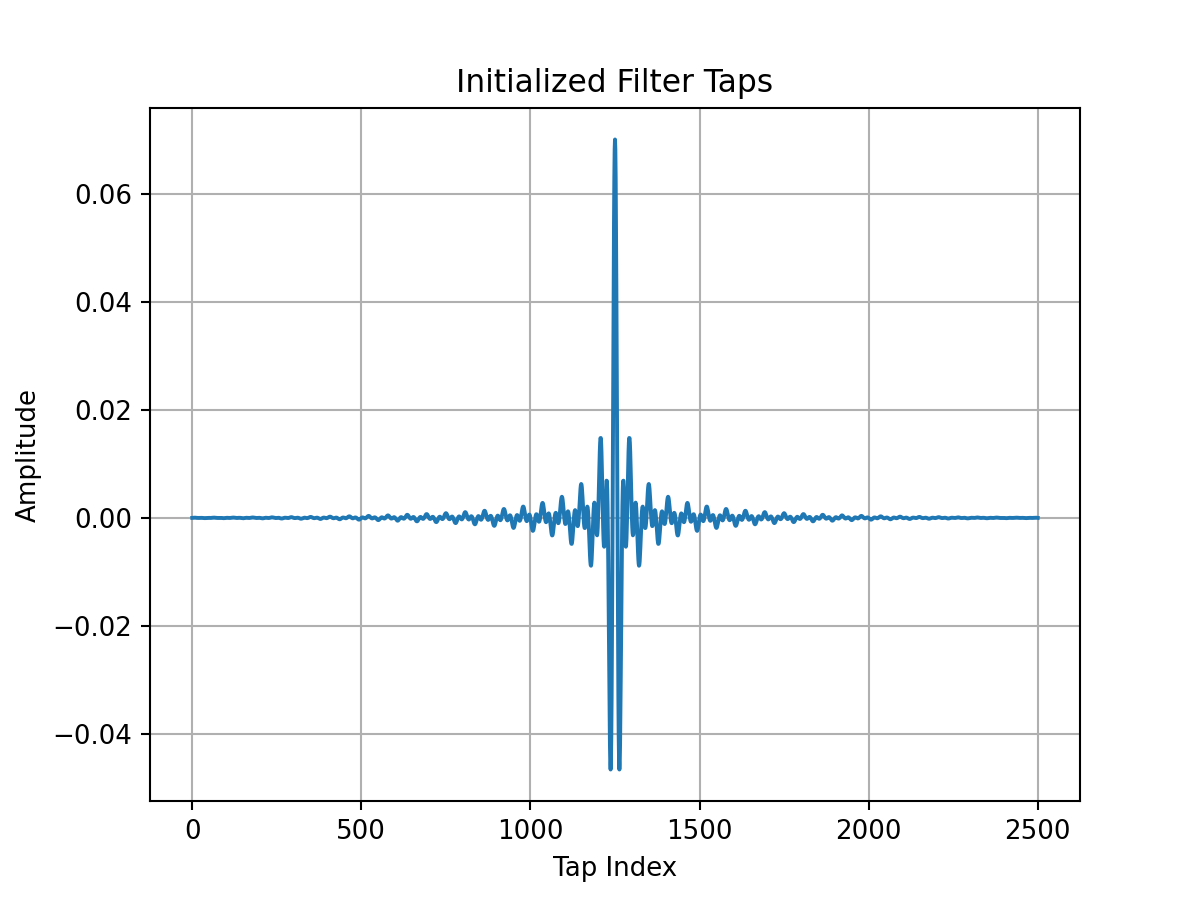

In [6]:
# Plot the initialized filter taps
plt.figure()
plt.plot(weigths_init[:])
plt.title("Initialized Filter Taps")
plt.xlabel("Tap Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


### Visualizing Frequency Response of the Filter
Understanding the frequency response provides insights into how the filter will behave across different frequencies.

<IPython.core.display.Javascript object>


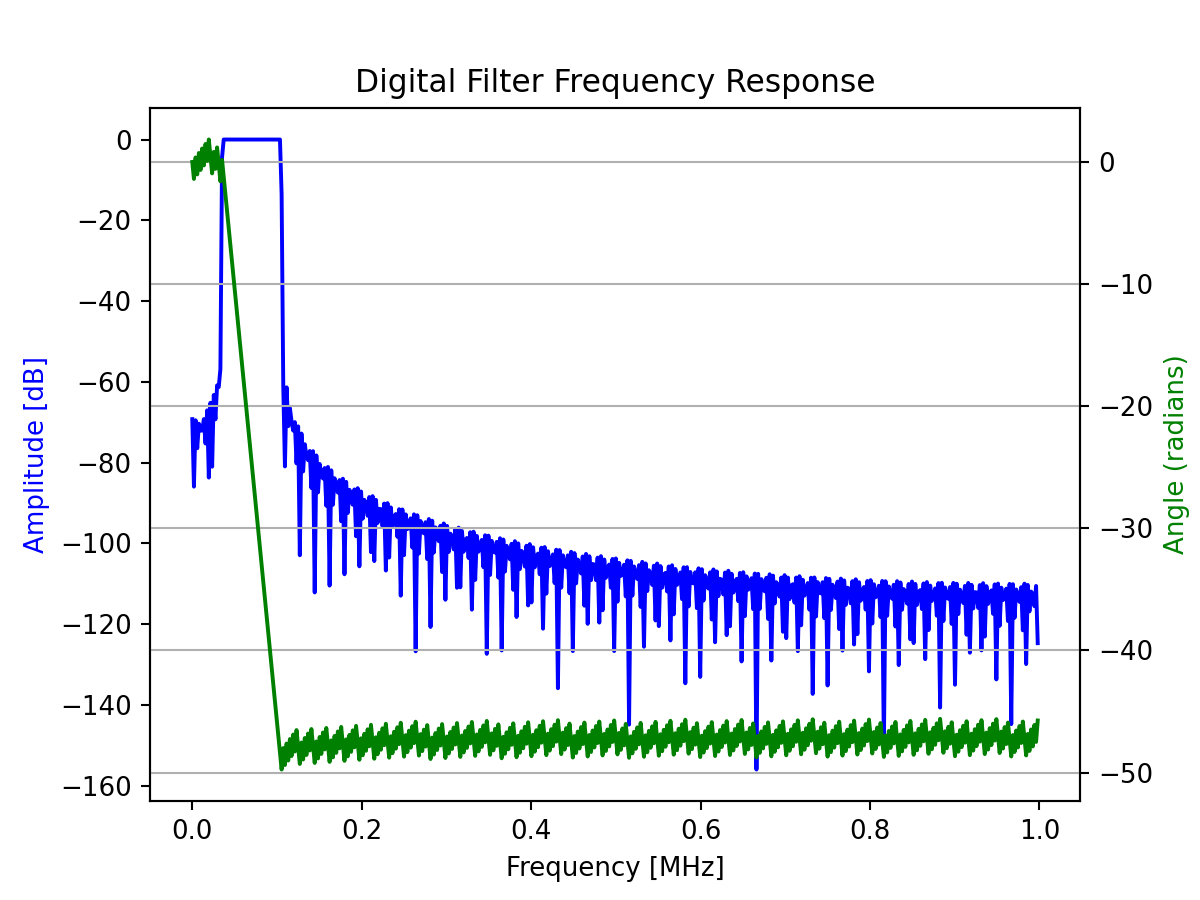

In [7]:
# Compute the frequency response of the filter
w, h = scipy.signal.freqz(weigths_init[:], fs=Fs)

# Plot the amplitude response
fig, ax1 = plt.subplots()
ax1.set_title('Digital Filter Frequency Response')
ax1.plot(w/1e6, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [MHz]')

# Plot the phase response on a secondary axis
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/1e6, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()


### Initializing Filter Taps for Conduction
Now, we initialize the filter taps specifically for the conduction regime.

In [8]:
weigths_init_cond = scipy.signal.firwin(size, [f1, f2], pass_zero='bandstop')

### Visualizing Frequency Response for Conduction
Let's visualize the frequency response for the conduction regime.

<IPython.core.display.Javascript object>


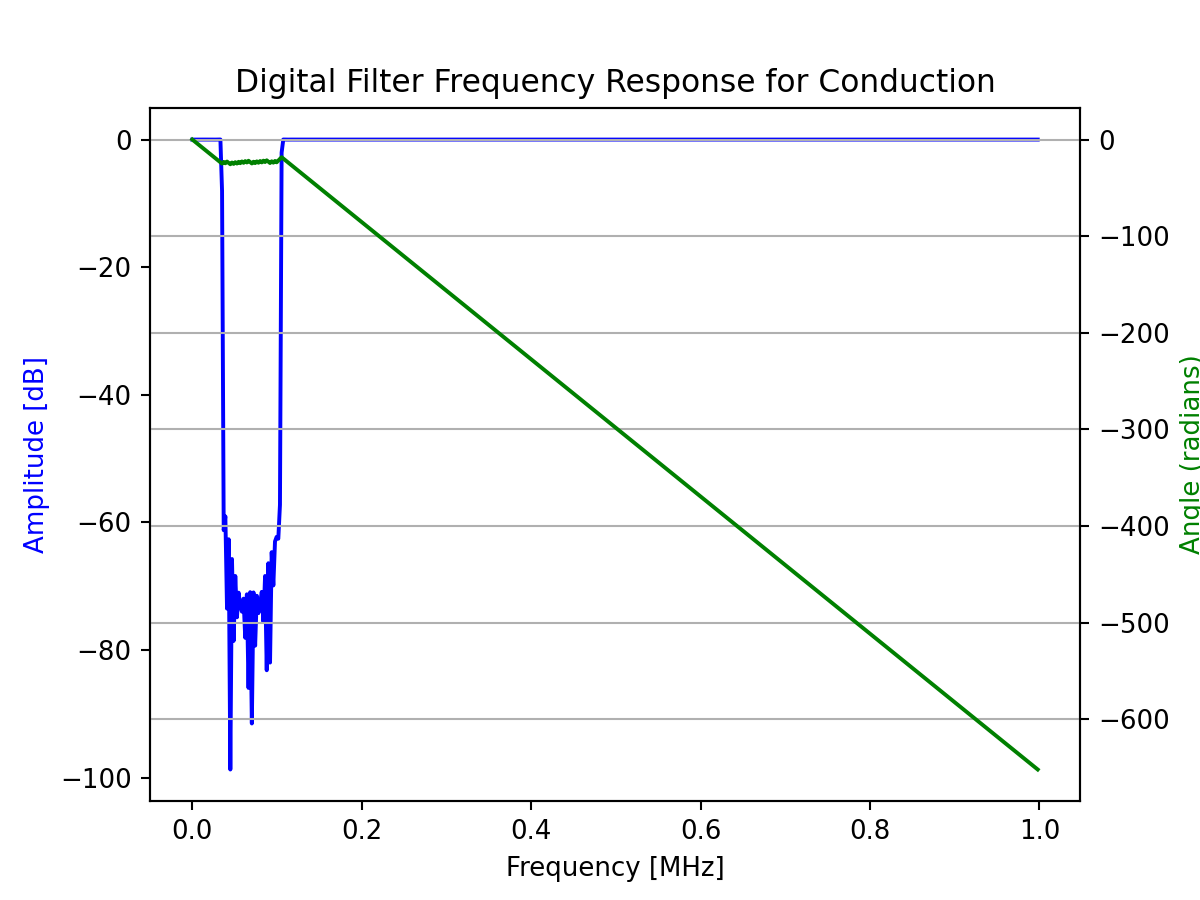

In [9]:
# Compute the frequency response for conduction filter
w, h = scipy.signal.freqz(weigths_init_cond[:], fs=Fs)

# Plot the amplitude response
fig, ax1 = plt.subplots()
ax1.set_title('Digital Filter Frequency Response for Conduction')
ax1.plot(w/1e6, 20 * np.log10(abs(h)), 'b')
ax1.set_ylabel('Amplitude [dB]', color='b')
ax1.set_xlabel('Frequency [MHz]')

# Plot the phase response on a secondary axis
ax2 = ax1.twinx()
angles = np.unwrap(np.angle(h))
ax2.plot(w/1e6, angles, 'g')
ax2.set_ylabel('Angle (radians)', color='g')
ax2.grid()
ax2.axis('tight')
plt.show()


### Loading Dataset
We load our acoustic signals and corresponding labels from a predefined directory.

In [10]:
xs = torch.load('./Database/Data')
GTs = torch.load('./Database/GTsTer')
names = torch.load('./Database/names')

Here, we turn our ground truth labels from ternary to binary.

In [11]:
newGTs = []
for GT in GTs:
    GT[torch.where(GT==2)] = 1
    newGTs.append(GT)

## Visualizing a Sample from the Dataset
Finally, we visualize a sample signal from our dataset alongside its ground truth labels.

<IPython.core.display.Javascript object>


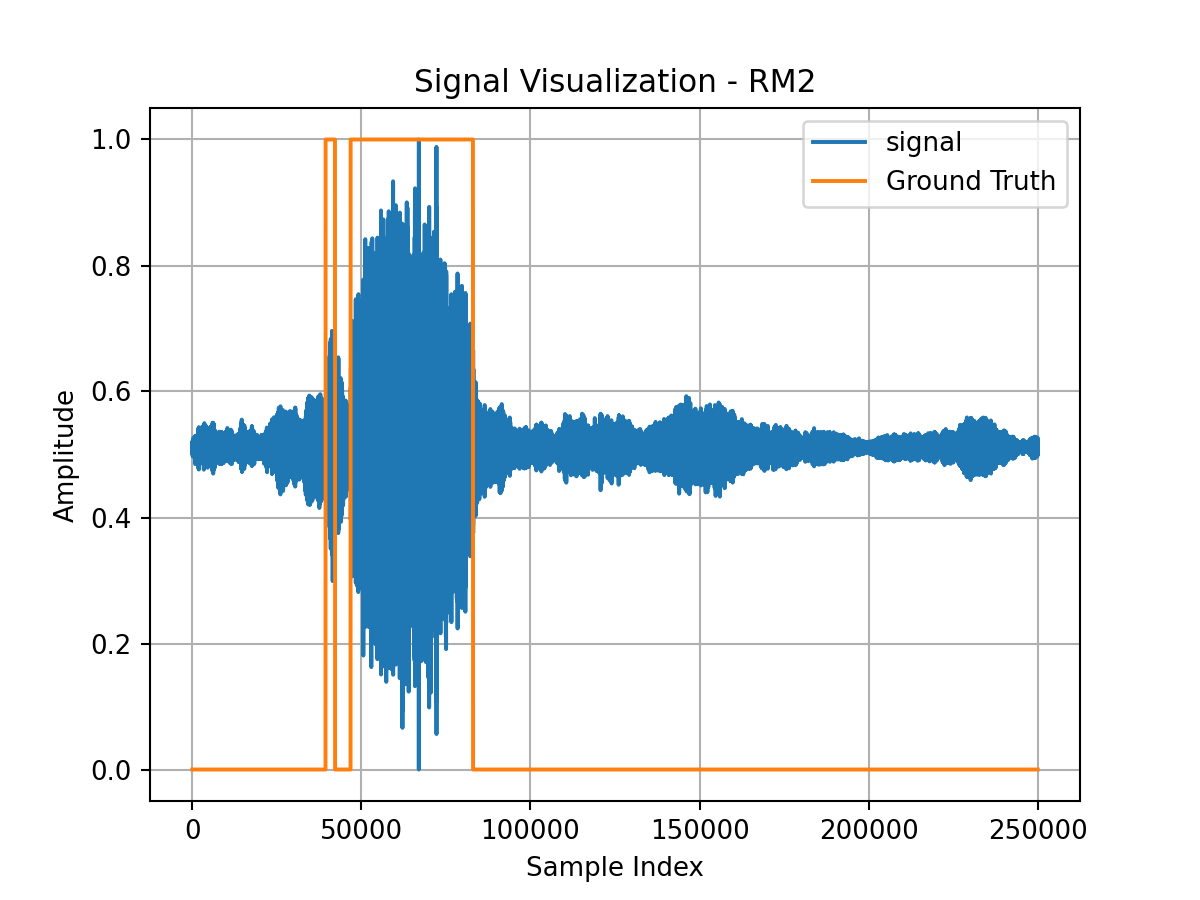

In [12]:
# Select a random index (for demonstration purposes, we've chosen index 1)
index = 1
plt.figure()
signal = xs[index].view(-1).numpy()
plt.plot((signal-min(signal))/(max(signal)-min(signal)), label='signal')
plt.plot(GTs[index], label='Ground Truth')
plt.legend()
plt.title(f"Signal Visualization - {names[index]}")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


### Adaptive Filter Model
Here, we define the adaptive filter architecture. Instead of the traditional approach of adjusting filter taps based on some algorithm, we are leveraging the power of gradient-based optimizations. Specifically, the weights (or taps) of this filter are learned adaptively during training.

In [13]:
class AdaptiveFilter(nn.Module):
    def __init__(self, weigths_init, size):
        super(AdaptiveFilter, self).__init__()
        
        # Calculate the size of the smoothing filter
        self.size = size * 4 + 1
        
        # Number of repetitions
        rep = 1
        
        # Convert the initial weights to a tensor and reshape it
        weights_init_torch = torch.tensor(weigths_init).view(1, 1, -1).float().repeat(rep, 1, 1)
        
        # Define the first filter and initialize with provided weights
        self.smooth_filtKH = torch.nn.Conv1d(in_channels=1, out_channels=rep, kernel_size=size, padding='same')
        self.smooth_filtKH.weight = torch.nn.Parameter(weights_init_torch)
        
        # Define the activation function - Parametric ReLU in this case
        self.prelu1 = torch.nn.PReLU()
        
        # Define the moving average and initialize it with uniform weights
        self.smooth_filt1 = torch.nn.Conv1d(in_channels=rep, out_channels=1, kernel_size=self.size, padding='same')
        self.smooth_filt1.weight = torch.nn.Parameter(torch.ones_like(self.smooth_filt1.weight) * 1/self.size * rep)
        
        # Disable training for the weights of the moving average
        self.smooth_filt1.weight.requires_grad = False

    def forward(self, x):
        # Compute the 95th and 5th percentiles for normalization
        myMax = torch.quantile(x, 0.95)
        myMin = torch.quantile(x, 0.05)
        
        # Normalize the input tensor
        x_norm = (x - myMin) / (myMax - myMin)
        
        # Apply the first filter
        smoothed_x = self.smooth_filtKH(F.pad(x_norm.view(1, 1, -1), (0, 0)))
        
        # Apply the activation function
        smoothed_x_energ = self.prelu1(smoothed_x)
        
        # Apply the moving average
        smoothed_x_energ_smooth = self.smooth_filt1(F.pad(smoothed_x_energ, (0, 0))).view(-1, 1)
        
        return smoothed_x_energ_smooth


### Setting the Computation Device
We check if GPU is available for computation. If not, we use the CPU.

In [14]:
# Set the computation device
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


### Initializing the Adaptive Filter
Next, we initialize our adaptive filter using the weights we defined for conduction and keyhole regimes.

In [15]:
# Initialize the adaptive filter for the two regimes
prediction = AdaptiveFilter(weigths_init_cond, size).to(device)
predictionKH = AdaptiveFilter(weigths_init, size).to(device)


### Function for Visualization
To visualize the performance of our adaptive filter, we define a plotting function.

In [16]:
def plot_adaptive_filter_output(prediction, predictionKH):
    """
    This function takes in the filtered signals for the two regimes (Conduction and Keyhole)
    and plots them alongside the original signal and ground truth.
    """
    for index in range(len(xs)):
        with torch.no_grad():
            # Get predictions for both regimes
            x_Cond = prediction(xs[index].view(-1).to(device))    
            x_KH = predictionKH(xs[index].view(-1).to(device))
            
            # Visualize the results
            plt.figure()
            signal = xs[index].view(-1).numpy()
            plt.plot((signal - min(signal)) / (max(signal) - min(signal)), label='Signal')
            
            combined_predictions = torch.cat([x_Cond, x_KH], 1)
            _, ind = torch.max(combined_predictions, 1)
            
            plt.plot(ind.detach().view(-1).cpu(), label='Prediction')
            plt.plot(GTs[index], label='Ground Truth')
            
            plt.legend()
            plt.title(f"Signal vs Prediction for {names[index]}")
            plt.xlabel("Sample Index")
            plt.ylabel("Amplitude")
            plt.grid(True)
            plt.show()


### Closure Function
This function calculates the loss (or "risk") for the model based on its predictions for all signals except the one being used for validation.

In [17]:
def closure():
    """
    Computes the loss for all signals except the validation one.
    """
    # Initialize variables to track total risk and number of samples
    risk = 0
    num_samples = 0
    
    # Loop through all signals
    for i in range(len(xs)):
        # Skip the validation signal
        if i != outer:
            # Load signal, ground truth, and name
            name = names[i]
            GT = GTs[i]
            signal = xs[i]
            
            # Transfer to computation device (GPU or CPU)
            GT = GT.to(device)
            signal = signal.to(device)

            # Make predictions using the models
            x_Cond = prediction(signal)
            x_KH = predictionKH(signal)
            myPreds = torch.cat([x_Cond, x_KH], 1)
            
            # Calculate the loss and update risk and num_samples
            loss_value = loss(myPreds, GT.view(-1).long())
            risk += loss_value.item()
            num_samples += myPreds.shape[0]
    
    # Return average risk
    return risk / (len(xs) - 1)


### Model Training
We will initiate the training process, iterating over each signal to use it as a validation set while training on the others (leave-one-out cross-validation).

For each iteration (i.e., each signal used as a validation set):

- The weights for the loss function are calculated based on the regime distribution.
- Models are trained using the LBFGS optimizer.
- Every few epochs, the model is evaluated on the validation set.
- The best model (in terms of F1 score) is saved.
- After training, the best model is loaded and evaluated on the validation set.

### Remarks
- The outer loop selects a signal to be used as a validation set, trains models on the other signals, and evaluates on the validation signal.
- The inner loop is the main training loop where the models are trained using the LBFGS optimizer.
- The closure function is used by the LBFGS optimizer to compute the loss.
- Model performance is evaluated using the F1 score.

Overall, the code is designed to train the filtering models to predict the melting regimes and evaluate their performance using leave-one-out cross-validation. 

In [18]:
# Enable anomaly detection to assist in debugging
torch.autograd.set_detect_anomaly(True)

# Define hyperparameters and settings for the training
lr = 5  # Learning rate
n_classes = 2  # Total number of regimes 
num_dec = 5  # Decimal precision for loss and F1 scores

# Set up the F1 score metric for performance evaluation
F1 = F1Score(task='multiclass', num_classes=n_classes, average='none').to(device)

# Initialize lists for tracking training and evaluation metrics
F1_scores = []
test_names = []
models_Cond = []
models_KH = []
models_Unst = []
models_2 = []
thsKH = [] 
thsUnst = []
K1s = []
K2s = []

# Use each signal as a validation set in a leave-one-out manner
for outer in range(len(xs)):
    print(f'Starting training excluding {names[outer]} from the training set...')
    
    # Variables to track the best observed risk and F1 score
    old_risk = 0
    min_risk = float('inf')
    best_f1 = 0

    # Calculate class weights based on their distribution in the dataset
    weights = np.zeros(n_classes)

    # Create a list of all GT tensors except the one for validation
    GT_list = [GTs[i] for i in range(len(xs)) if i != outer]

    # Calculate the total number of samples excluding the validation set
    total = sum(GT.shape[0] for GT in GT_list)

    # Calculate the weights for each class
    for c in range(n_classes):
        class_count = sum(torch.sum(GT == c).item() for GT in GT_list)
        weights[c] = total / (n_classes * class_count)
    for c, weight in enumerate(weights):
        print(f'Weight for class {c}: {weight}')

    # Define the loss function with the computed class weights
    loss = torch.nn.CrossEntropyLoss(weight=torch.tensor(weights).float().to(device))
    
    # Training loop control variables
    done = False
    n = 0
    
    # Main training loop
    while not done:
        print(f'Starting epoch {n}...')
        
        # Periodically reinitialize the optimizer
        if n % 1000 == 0 or time_is_now:
            print('Reinitializing optimizer with learning rate:', lr)
            params = list(prediction.parameters()) + list(predictionKH.parameters())
            optimizer = optim.LBFGS(params, lr=lr, line_search_fn="strong_wolfe")
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', verbose=True)
            time_is_now = False

        risk = 0
        scores, predictions, groundis = [], [], []

        # Zero out optimizer gradients
        optimizer.zero_grad()

        # Training over all signals except the validation one
        for i in range(len(xs)):
            if i != outer:
                # Get current signal, ground truth, and name
                name, GT, signal = names[i], GTs[i], xs[i]

                # Transfer data to the specified device
                GT, signal = GT.to(device), signal.to(device)

                # Obtain model predictions for the current signal
                x_Cond, x_KH = prediction(signal), predictionKH(signal)
                myPreds = torch.cat([x_Cond, x_KH], 1)
                
                # Compute loss
                loss_value = loss(myPreds, GT.view(-1).long())
                risk += loss_value

                # Store predictions and actual values for F1 score computation
                _, ind = torch.max(myPreds, 1)
                predictions.append(ind.long())
                groundis.append(GT.view(-1).long())
                
                # Compute and store the F1 score for current signal
                score = F1(ind.long(), GT.view(-1).long())
                scores.append(score.view(1, -1))
                print(f'F1-score for {name}:', score.to('cpu').detach())
        
        # Average risk over all training signals
        risk /= len(xs) - 1

        # Save model if current risk is a new minimum
        if risk.item() < min_risk:
            min_risk = risk.item()
            torch.save(prediction, f'./PocketModels/prediction10_{outer}')   
            torch.save(predictionKH, f'./PocketModels/predictionKH10_{outer}')   

        # Compute overall F1 score
        f1_score_total = F1(torch.cat(predictions), torch.cat(groundis))
        print(f'Average Risk: {round(risk.item(), num_dec)}, Minimum Risk observed: {round(min_risk, num_dec)}')
        print(f'Overall F1-score - Condition: {f1_score_total[0].item()}, KH State: {f1_score_total[1].item()}')
        print('-' * 57)

        # Periodically evaluate on validation set
        if n % 2 == 0:
            with torch.no_grad():
                name, GT, signal = names[outer], GTs[outer], xs[outer]
                GT, signal = GT.to(device), signal.to(device)
                x_Cond, x_KH = prediction(signal), predictionKH(signal)
                myPreds = torch.cat([x_Cond, x_KH], 1)
                _, ind = torch.max(myPreds, 1)
                score = F1(ind.long(), GT.view(-1).long())
                
                # Update best F1 score if current score is better
                if torch.mean(score) > best_f1:
                    best_f1 = torch.mean(score)
                    myN = n
                    myF1 = score.cpu().detach()
                print(f'Validation F1-score for {name}:', score.cpu().detach())
                print(f'Best F1 score observed: {myF1} at epoch {myN}')
                print('-' * 200)

        n += 1
        # Termination conditions for the training loop
        if n >= n_iters and min_risk < 0.15 or n >= 10000:
            done = True
        
        scheduler.step(risk)
        risk.backward()
        optimizer.step(closure)

        # Reinitialize optimizer if risk hasn't changed
        if risk.clone().item() == old_risk:
            time_is_now = True
        old_risk = risk.clone().item()

    # Load best models after training loop
    prediction = torch.load(f'./PocketModels/prediction10_{outer}')   
    predictionKH = torch.load(f'./PocketModels/predictionKH10_{outer}')   

    # Evaluate on the validation set and store results
    with torch.no_grad():
        name, GT, signal = names[outer], GTs[outer], xs[outer]
        GT, signal = GT.to(device), signal.to(device)
        x_Cond, x_KH = prediction(signal), predictionKH(signal)
        myPreds = torch.cat([x_Cond, x_KH], 1)
        _, ind = torch.max(myPreds, 1)
        score = F1(ind.long(), GT.view(-1).long())
        print(f'Final Validation F1-score for {name}:', score.cpu().detach())
        print('-' * 200)

        F1_scores.append(score.view(1, -1))
        test_names.append(name)
        models_Cond.append(prediction)
        models_KH.append(predictionKH)

    # Reset models for next iteration
    prediction = AdaptiveFilter(weigths_init_cond, size).to(device)
    predictionKH = AdaptiveFilter(weigths_init, size).to(device)


Starting training excluding RM1 from the training set...
Weight for class 0: 1.7571730433975876
Weight for class 1: 0.6988588614057135
Starting epoch 0...
Reinitializing optimizer with learning rate: 5
F1-score for RM2: tensor([0.9154, 0.0000])
F1-score for RM3: tensor([0.3826, 0.0000])
F1-score for RM4: tensor([0.1197, 0.0000])
F1-score for RM5: tensor([0.2421, 0.0000])
F1-score for RM6: tensor([0.5571, 0.0000])
F1-score for RM7_1: tensor([0.3325, 0.0000])
F1-score for RM7_2: tensor([0.3897, 0.0000])
F1-score for RM7_3: tensor([0.3113, 0.0000])
Average Risk: 0.72064, Minimum Risk observed: 0.72064
Overall F1-score - Condition: 0.44303205609321594, KH State: 0.0
---------------------------------------------------------
Validation F1-score for RM1: tensor([0.4633, 0.0000])
Best F1 score observed: tensor([0.4633, 0.0000]) at epoch 0
-------------------------------------------------------------------------------------------------------------------------------------------------------------

F1-score for RM6: tensor([0.9759, 0.9854])
F1-score for RM7_1: tensor([0.9937, 0.9984])
F1-score for RM7_2: tensor([0.9626, 0.9886])
F1-score for RM7_3: tensor([0.9637, 0.9922])
Average Risk: 0.17546, Minimum Risk observed: 0.17546
Overall F1-score - Condition: 0.9624876379966736, KH State: 0.9857158660888672
---------------------------------------------------------
Starting epoch 12...
F1-score for RM2: tensor([0.9516, 0.8002])
F1-score for RM3: tensor([0.9594, 0.9877])
F1-score for RM4: tensor([0.8325, 0.9875])
F1-score for RM5: tensor([0.8340, 0.9778])
F1-score for RM6: tensor([0.9760, 0.9855])
F1-score for RM7_1: tensor([0.9937, 0.9984])
F1-score for RM7_2: tensor([0.9626, 0.9886])
F1-score for RM7_3: tensor([0.9641, 0.9922])
Average Risk: 0.17546, Minimum Risk observed: 0.17546
Overall F1-score - Condition: 0.9625980257987976, KH State: 0.9857543110847473
---------------------------------------------------------
Validation F1-score for RM1: tensor([0.9131, 0.9600])
Best F1 score o

Starting epoch 23...
F1-score for RM2: tensor([0.9764, 0.8890])
F1-score for RM3: tensor([0.9663, 0.9892])
F1-score for RM4: tensor([0.7737, 0.9817])
F1-score for RM5: tensor([0.9270, 0.9893])
F1-score for RM6: tensor([0.9906, 0.9942])
F1-score for RM7_1: tensor([0.9888, 0.9972])
F1-score for RM7_2: tensor([0.9687, 0.9903])
F1-score for RM7_3: tensor([0.9815, 0.9959])
Average Risk: 0.1069, Minimum Risk observed: 0.1069
Overall F1-score - Condition: 0.97542405128479, KH State: 0.9903612732887268
---------------------------------------------------------
Starting epoch 24...
F1-score for RM2: tensor([0.9764, 0.8890])
F1-score for RM3: tensor([0.9663, 0.9892])
F1-score for RM4: tensor([0.7737, 0.9817])
F1-score for RM5: tensor([0.9270, 0.9893])
F1-score for RM6: tensor([0.9906, 0.9942])
F1-score for RM7_1: tensor([0.9888, 0.9972])
F1-score for RM7_2: tensor([0.9687, 0.9903])
F1-score for RM7_3: tensor([0.9815, 0.9959])
Average Risk: 0.1069, Minimum Risk observed: 0.1069
Overall F1-score - 

F1-score for RM7_2: tensor([0.9698, 0.9906])
F1-score for RM7_3: tensor([0.9821, 0.9960])
Average Risk: 0.10485, Minimum Risk observed: 0.10485
Overall F1-score - Condition: 0.9748080968856812, KH State: 0.9900672435760498
---------------------------------------------------------
Validation F1-score for RM1: tensor([0.8405, 0.9154])
Best F1 score observed: tensor([0.9131, 0.9600]) at epoch 12
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 35...
F1-score for RM2: tensor([0.9756, 0.8859])
F1-score for RM3: tensor([0.9637, 0.9883])
F1-score for RM4: tensor([0.7440, 0.9784])
F1-score for RM5: tensor([0.8962, 0.9841])
F1-score for RM6: tensor([0.9954, 0.9971])
F1-score for RM7_1: tensor([0.9831, 0.9957])
F1-score for RM7_2: tensor([0.9712, 0.9910])
F1-score for RM7_3: tensor([0.9807, 0.9957])
Average Risk: 0.10012, Minimum R

Starting epoch 46...
F1-score for RM2: tensor([0.9758, 0.8866])
F1-score for RM3: tensor([0.9641, 0.9884])
F1-score for RM4: tensor([0.7492, 0.9790])
F1-score for RM5: tensor([0.9001, 0.9847])
F1-score for RM6: tensor([0.9942, 0.9964])
F1-score for RM7_1: tensor([0.9837, 0.9959])
F1-score for RM7_2: tensor([0.9705, 0.9908])
F1-score for RM7_3: tensor([0.9815, 0.9959])
Average Risk: 0.09941, Minimum Risk observed: 0.09941
Overall F1-score - Condition: 0.9743363857269287, KH State: 0.9898713231086731
---------------------------------------------------------
Validation F1-score for RM1: tensor([0.8416, 0.9161])
Best F1 score observed: tensor([0.9131, 0.9600]) at epoch 12
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 47...
F1-score for RM2: tensor([0.9756, 0.8858])
F1-score for RM3: tensor([0.9647, 0.9886])
F1-score for RM

Starting epoch 7...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66963, Minimum Risk observed: 0.66963
Overall F1-score - Condition: 0.0, KH State: 0.8693647980690002
---------------------------------------------------------
Starting epoch 8...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66962, Minimum Risk observed: 0.66962
Overall F1-score - Condition: 

Starting epoch 19...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66955, Minimum Risk observed: 0.66955
Overall F1-score - Condition: 0.0, KH State: 0.8693647980690002
---------------------------------------------------------
Starting epoch 20...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66954, Minimum Risk observed: 0.66954
Overall F1-score - Condition

Starting epoch 36...
F1-score for RM1: tensor([0.9554, 0.9811])
F1-score for RM3: tensor([0.9513, 0.9841])
F1-score for RM4: tensor([0.6915, 0.9718])
F1-score for RM5: tensor([0.8958, 0.9840])
F1-score for RM6: tensor([0.9970, 0.9981])
F1-score for RM7_1: tensor([0.9793, 0.9947])
F1-score for RM7_2: tensor([0.9607, 0.9876])
F1-score for RM7_3: tensor([0.9726, 0.9938])
Average Risk: 0.11061, Minimum Risk observed: 0.11061
Overall F1-score - Condition: 0.9647834300994873, KH State: 0.9893015623092651
---------------------------------------------------------
Validation F1-score for RM2: tensor([0.8600, 0.6007])
Best F1 score observed: tensor([0.9109, 0.6931]) at epoch 24
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 37...
F1-score for RM1: tensor([0.9226, 0.9646])
F1-score for RM3: tensor([0.9605, 0.9873])
F1-score for RM

F1-score for RM6: tensor([0.9984, 0.9990])
F1-score for RM7_1: tensor([0.9781, 0.9944])
F1-score for RM7_2: tensor([0.9601, 0.9874])
F1-score for RM7_3: tensor([0.9750, 0.9944])
Average Risk: 0.09425, Minimum Risk observed: 0.09425
Overall F1-score - Condition: 0.9667363166809082, KH State: 0.9899186491966248
---------------------------------------------------------
Starting epoch 48...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tensor([0.9605, 0.9831])
F1-score for RM3: tensor([0.9552, 0.9854])
F1-score for RM4: tensor([0.7139, 0.9747])
F1-score for RM5: tensor([0.8893, 0.9829])
F1-score for RM6: tensor([0.9960, 0.9975])
F1-score for RM7_1: tensor([0.9764, 0.9940])
F1-score for RM7_2: tensor([0.9575, 0.9863])
F1-score for RM7_3: tensor([0.9727, 0.9938])
Average Risk: 0.09336, Minimum Risk observed: 0.09336
Overall F1-score - Condition: 0.9649848937988281, KH State: 0.9892996549606323
---------------------------------------------------------
Validation F1-score fo

F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.67132, Minimum Risk observed: 0.67132
Overall F1-score - Condition: 0.0, KH State: 0.8284905552864075
---------------------------------------------------------
Validation F1-score for RM3: tensor([0.0000, 0.8658])
Best F1 score observed: tensor([0.0000, 0.8658]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 9...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.67121, Minimum Risk observed: 0.6

F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66824, Minimum Risk observed: 0.66824
Overall F1-score - Condition: 0.0, KH State: 0.8284905552864075
---------------------------------------------------------
Validation F1-score for RM3: tensor([0.0000, 0.8658])
Best F1 score observed: tensor([0.0000, 0.8658]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 21...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-sc

Starting epoch 32...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66683, Minimum Risk observed: 0.66683
Overall F1-score - Condition: 0.0, KH State: 0.8284905552864075
---------------------------------------------------------
Validation F1-score for RM3: tensor([0.0000, 0.8658])
Best F1 score observed: tensor([0.0000, 0.8658]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 33...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM4: tensor([0.000

F1-score for RM6: tensor([0.9887, 0.9930])
F1-score for RM7_1: tensor([0.9886, 0.9971])
F1-score for RM7_2: tensor([0.9666, 0.9897])
F1-score for RM7_3: tensor([0.9802, 0.9956])
Average Risk: 0.14431, Minimum Risk observed: 0.14431
Overall F1-score - Condition: 0.9599395990371704, KH State: 0.9834036231040955
---------------------------------------------------------
Starting epoch 44...
F1-score for RM1: tensor([0.8503, 0.9221])
F1-score for RM2: tensor([0.9750, 0.8836])
F1-score for RM4: tensor([0.7427, 0.9782])
F1-score for RM5: tensor([0.9218, 0.9885])
F1-score for RM6: tensor([0.9890, 0.9932])
F1-score for RM7_1: tensor([0.9880, 0.9970])
F1-score for RM7_2: tensor([0.9668, 0.9898])
F1-score for RM7_3: tensor([0.9802, 0.9956])
Average Risk: 0.14426, Minimum Risk observed: 0.14426
Overall F1-score - Condition: 0.9598994255065918, KH State: 0.983371376991272
---------------------------------------------------------
Validation F1-score for RM3: tensor([0.9612, 0.9875])
Best F1 score ob

F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.68025, Minimum Risk observed: 0.68025
Overall F1-score - Condition: 0.0, KH State: 0.8270941972732544
---------------------------------------------------------
Validation F1-score for RM4: tensor([0.0000, 0.9671])
Best F1 score observed: tensor([0.0000, 0.9671]) at epoch 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 5...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score

Starting epoch 16...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.67214, Minimum Risk observed: 0.67214
Overall F1-score - Condition: 0.0, KH State: 0.8270941972732544
---------------------------------------------------------
Validation F1-score for RM4: tensor([0.0000, 0.9671])
Best F1 score observed: tensor([0.0000, 0.9671]) at epoch 4
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 17...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.000

F1-score for RM7_2: tensor([0.9740, 0.9918])
F1-score for RM7_3: tensor([0.9757, 0.9946])
Average Risk: 0.11828, Minimum Risk observed: 0.11828
Overall F1-score - Condition: 0.9601620435714722, KH State: 0.983034610748291
---------------------------------------------------------
Starting epoch 28...
F1-score for RM1: tensor([0.8387, 0.9144])
F1-score for RM2: tensor([0.9728, 0.8652])
F1-score for RM3: tensor([0.9588, 0.9867])
F1-score for RM5: tensor([0.8816, 0.9815])
F1-score for RM6: tensor([0.9972, 0.9982])
F1-score for RM7_1: tensor([0.9827, 0.9956])
F1-score for RM7_2: tensor([0.9727, 0.9914])
F1-score for RM7_3: tensor([0.9765, 0.9947])
Average Risk: 0.11777, Minimum Risk observed: 0.11777
Overall F1-score - Condition: 0.9604076743125916, KH State: 0.9831644296646118
---------------------------------------------------------
Validation F1-score for RM4: tensor([0.3701, 0.8830])
Best F1 score observed: tensor([0.3701, 0.8830]) at epoch 28
-------------------------------------------

Starting epoch 39...
F1-score for RM1: tensor([0.8422, 0.9165])
F1-score for RM2: tensor([0.9745, 0.8816])
F1-score for RM3: tensor([0.9634, 0.9881])
F1-score for RM5: tensor([0.8889, 0.9828])
F1-score for RM6: tensor([0.9994, 0.9996])
F1-score for RM7_1: tensor([0.9821, 0.9955])
F1-score for RM7_2: tensor([0.9719, 0.9912])
F1-score for RM7_3: tensor([0.9786, 0.9952])
Average Risk: 0.10204, Minimum Risk observed: 0.10204
Overall F1-score - Condition: 0.9621290564537048, KH State: 0.9839625358581543
---------------------------------------------------------
Starting epoch 40...
F1-score for RM1: tensor([0.8409, 0.9153])
F1-score for RM2: tensor([0.9766, 0.8898])
F1-score for RM3: tensor([0.9633, 0.9881])
F1-score for RM5: tensor([0.8608, 0.9776])
F1-score for RM6: tensor([0.9978, 0.9986])
F1-score for RM7_1: tensor([0.9801, 0.9949])
F1-score for RM7_2: tensor([0.9742, 0.9919])
F1-score for RM7_3: tensor([0.9773, 0.9949])
Average Risk: 0.10081, Minimum Risk observed: 0.10081
Overall F1-sc

F1-score for RM3: tensor([0.3826, 0.0000])
F1-score for RM4: tensor([0.1197, 0.0000])
F1-score for RM6: tensor([0.5571, 0.0000])
F1-score for RM7_1: tensor([0.3325, 0.0000])
F1-score for RM7_2: tensor([0.3897, 0.0000])
F1-score for RM7_3: tensor([0.3113, 0.0000])
Average Risk: 0.7118, Minimum Risk observed: 0.7118
Overall F1-score - Condition: 0.44988366961479187, KH State: 0.0
---------------------------------------------------------
Validation F1-score for RM5: tensor([0.2421, 0.0000])
Best F1 score observed: tensor([0.2421, 0.0000]) at epoch 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 1...
F1-score for RM1: tensor([0.7649, 0.8587])
F1-score for RM2: tensor([0.9772, 0.8837])
F1-score for RM3: tensor([0.8872, 0.9688])
F1-score for RM4: tensor([0.1894, 0.5896])
F1-score for RM6: tensor([0.9817, 0.9888])
F1-score fo

F1-score for RM7_2: tensor([0.8589, 0.9447])
F1-score for RM7_3: tensor([0.9018, 0.9755])
Average Risk: 0.6786, Minimum Risk observed: 0.6786
Overall F1-score - Condition: 0.8418070673942566, KH State: 0.9177663326263428
---------------------------------------------------------
Starting epoch 12...
F1-score for RM1: tensor([0.6397, 0.6855])
F1-score for RM2: tensor([0.9856, 0.9227])
F1-score for RM3: tensor([0.8731, 0.9528])
F1-score for RM4: tensor([0.1316, 0.1869])
F1-score for RM6: tensor([0.9600, 0.9731])
F1-score for RM7_1: tensor([0.9016, 0.9721])
F1-score for RM7_2: tensor([0.8597, 0.9450])
F1-score for RM7_3: tensor([0.9058, 0.9766])
Average Risk: 0.67858, Minimum Risk observed: 0.67858
Overall F1-score - Condition: 0.8431538939476013, KH State: 0.9186722040176392
---------------------------------------------------------
Validation F1-score for RM5: tensor([0.2421, 0.0000])
Best F1 score observed: tensor([0.2421, 0.0000]) at epoch 0
---------------------------------------------

Starting epoch 23...
F1-score for RM1: tensor([0.5448, 0.6786])
F1-score for RM2: tensor([0.8228, 0.5287])
F1-score for RM3: tensor([0.4515, 0.8511])
F1-score for RM4: tensor([0.0000, 0.4387])
F1-score for RM6: tensor([0.4391, 0.8157])
F1-score for RM7_1: tensor([0.3118, 0.9078])
F1-score for RM7_2: tensor([0.7304, 0.9345])
F1-score for RM7_3: tensor([0.2096, 0.9093])
Average Risk: 0.60027, Minimum Risk observed: 0.60027
Overall F1-score - Condition: 0.5495325922966003, KH State: 0.8528133034706116
---------------------------------------------------------
Starting epoch 24...
F1-score for RM1: tensor([0.6281, 0.6664])
F1-score for RM2: tensor([0.9296, 0.7152])
F1-score for RM3: tensor([0.5867, 0.8561])
F1-score for RM4: tensor([0.0484, 0.2595])
F1-score for RM6: tensor([0.5440, 0.8355])
F1-score for RM7_1: tensor([0.5309, 0.9263])
F1-score for RM7_2: tensor([0.7824, 0.9424])
F1-score for RM7_3: tensor([0.6100, 0.9389])
Average Risk: 0.5949, Minimum Risk observed: 0.5949
Overall F1-scor

Starting epoch 35...
F1-score for RM1: tensor([0.8321, 0.9088])
F1-score for RM2: tensor([0.9760, 0.8825])
F1-score for RM3: tensor([0.9577, 0.9861])
F1-score for RM4: tensor([0.2296, 0.7397])
F1-score for RM6: tensor([0.9943, 0.9964])
F1-score for RM7_1: tensor([0.9759, 0.9939])
F1-score for RM7_2: tensor([0.9738, 0.9915])
F1-score for RM7_3: tensor([0.9695, 0.9931])
Average Risk: 0.18861, Minimum Risk observed: 0.18861
Overall F1-score - Condition: 0.9358110427856445, KH State: 0.9719703197479248
---------------------------------------------------------
Starting epoch 36...
F1-score for RM1: tensor([0.8358, 0.9126])
F1-score for RM2: tensor([0.9735, 0.8711])
F1-score for RM3: tensor([0.9588, 0.9868])
F1-score for RM4: tensor([0.4154, 0.9052])
F1-score for RM6: tensor([0.9959, 0.9974])
F1-score for RM7_1: tensor([0.9832, 0.9957])
F1-score for RM7_2: tensor([0.9731, 0.9915])
F1-score for RM7_3: tensor([0.9774, 0.9949])
Average Risk: 0.18141, Minimum Risk observed: 0.18141
Overall F1-sc

Starting epoch 47...
F1-score for RM1: tensor([0.8653, 0.9319])
F1-score for RM2: tensor([0.9684, 0.8579])
F1-score for RM3: tensor([0.9590, 0.9868])
F1-score for RM4: tensor([0.7124, 0.9745])
F1-score for RM6: tensor([0.9975, 0.9985])
F1-score for RM7_1: tensor([0.9809, 0.9951])
F1-score for RM7_2: tensor([0.9697, 0.9905])
F1-score for RM7_3: tensor([0.9772, 0.9949])
Average Risk: 0.13145, Minimum Risk observed: 0.13145
Overall F1-score - Condition: 0.9602513909339905, KH State: 0.9835832118988037
---------------------------------------------------------
Starting epoch 48...
F1-score for RM1: tensor([0.8762, 0.9386])
F1-score for RM2: tensor([0.9680, 0.8563])
F1-score for RM3: tensor([0.9592, 0.9868])
F1-score for RM4: tensor([0.7183, 0.9753])
F1-score for RM6: tensor([0.9968, 0.9980])
F1-score for RM7_1: tensor([0.9816, 0.9953])
F1-score for RM7_2: tensor([0.9694, 0.9904])
F1-score for RM7_3: tensor([0.9777, 0.9950])
Average Risk: 0.13119, Minimum Risk observed: 0.13119
Overall F1-sc

F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.67, Minimum Risk observed: 0.67
Overall F1-score - Condition: 0.0, KH State: 0.8399543166160583
---------------------------------------------------------
Validation F1-score for RM6: tensor([0.0000, 0.7608])
Best F1 score observed: tensor([0.0000, 0.7608]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 9...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for

Starting epoch 20...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66714, Minimum Risk observed: 0.66714
Overall F1-score - Condition: 0.0, KH State: 0.8399543166160583
---------------------------------------------------------
Validation F1-score for RM6: tensor([0.0000, 0.7608])
Best F1 score observed: tensor([0.0000, 0.7608]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 21...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tenso

F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66612, Minimum Risk observed: 0.66612
Overall F1-score - Condition: 0.0, KH State: 0.8399543166160583
---------------------------------------------------------
Starting epoch 32...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66611, Minimum Risk observed: 0.66611
Overall F1-score - Condition: 0.0, KH State: 0.8399543166160583
---------------------------------------------------------
Validatio

Starting epoch 43...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66605, Minimum Risk observed: 0.66605
Overall F1-score - Condition: 0.0, KH State: 0.8399543166160583
---------------------------------------------------------
Starting epoch 44...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66605, Minimum Risk

Validation F1-score for RM6: tensor([0.9925, 0.9953])
Best F1 score observed: tensor([0.9925, 0.9953]) at epoch 54
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Final Validation F1-score for RM6: tensor([0.9925, 0.9953])
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting training excluding RM7_1 from the training set...
Weight for class 0: 1.6375476725729183
Weight for class 1: 0.7197710091872872
Starting epoch 0...
Reinitializing optimizer with learning rate: 5
F1-score for RM1: tensor([0.4633, 0.0000])
F1-score for RM2: tensor([0.9154, 0.0000])
F1-score for RM3: tensor([0.3826, 0.0000])
F1-score for RM4: tensor([0.1197, 0.0000])
F1-score for RM5: tensor([0.2421, 0.0000])
F1-s

Validation F1-score for RM7_1: tensor([0.0000, 0.8892])
Best F1 score observed: tensor([0.0000, 0.8892]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 11...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.68274, Minimum Risk observed: 0.68274
Overall F1-score - Condition: 0.0, KH State: 0.8198260068893433
---------------------------------------------------------
Starting epoch 12...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.000

F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66327, Minimum Risk observed: 0.66327
Overall F1-score - Condition: 0.0, KH State: 0.8198260068893433
---------------------------------------------------------
Validation F1-score for RM7_1: tensor([0.0000, 0.8892])
Best F1 score observed: tensor([0.0000, 0.8892]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 23...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66276, Minimum Risk observed: 0.

F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_2: tensor([0.0000, 0.8623])
F1-score for RM7_3: tensor([0.0000, 0.8985])
Average Risk: 0.66208, Minimum Risk observed: 0.66208
Overall F1-score - Condition: 0.0, KH State: 0.8198260068893433
---------------------------------------------------------
Validation F1-score for RM7_1: tensor([0.0000, 0.8892])
Best F1 score observed: tensor([0.0000, 0.8892]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 35...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score 

Starting epoch 46...
F1-score for RM1: tensor([0.9565, 0.9815])
F1-score for RM2: tensor([0.8682, 0.6134])
F1-score for RM3: tensor([0.9533, 0.9849])
F1-score for RM4: tensor([0.6851, 0.9709])
F1-score for RM5: tensor([0.9041, 0.9852])
F1-score for RM6: tensor([0.9932, 0.9957])
F1-score for RM7_2: tensor([0.9602, 0.9872])
F1-score for RM7_3: tensor([0.9738, 0.9941])
Average Risk: 0.43165, Minimum Risk observed: 0.43165
Overall F1-score - Condition: 0.935904324054718, KH State: 0.9729167819023132
---------------------------------------------------------
Validation F1-score for RM7_1: tensor([0.9804, 0.9950])
Best F1 score observed: tensor([0.9804, 0.9950]) at epoch 46
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 47...
F1-score for RM1: tensor([0.9550, 0.9808])
F1-score for RM2: tensor([0.9196, 0.7130])
F1-score for RM3

F1-score for RM7_2: tensor([0.9702, 0.9906])
F1-score for RM7_3: tensor([0.9802, 0.9956])
Average Risk: 0.39363, Minimum Risk observed: 0.39363
Overall F1-score - Condition: 0.9545301198959351, KH State: 0.9796798229217529
---------------------------------------------------------
Starting epoch 58...
F1-score for RM1: tensor([0.8454, 0.9197])
F1-score for RM2: tensor([0.9683, 0.8576])
F1-score for RM3: tensor([0.9572, 0.9862])
F1-score for RM4: tensor([0.6699, 0.9687])
F1-score for RM5: tensor([0.8845, 0.9820])
F1-score for RM6: tensor([0.9946, 0.9965])
F1-score for RM7_2: tensor([0.9692, 0.9902])
F1-score for RM7_3: tensor([0.9778, 0.9950])
Average Risk: 0.39103, Minimum Risk observed: 0.39103
Overall F1-score - Condition: 0.9522156119346619, KH State: 0.9786104559898376
---------------------------------------------------------
Validation F1-score for RM7_1: tensor([0.9835, 0.9958])
Best F1 score observed: tensor([0.9835, 0.9958]) at epoch 58
------------------------------------------

Starting epoch 69...
F1-score for RM1: tensor([0.9366, 0.9738])
F1-score for RM2: tensor([0.8100, 0.5365])
F1-score for RM3: tensor([0.9279, 0.9771])
F1-score for RM4: tensor([0.5813, 0.9536])
F1-score for RM5: tensor([0.8963, 0.9841])
F1-score for RM6: tensor([0.9880, 0.9923])
F1-score for RM7_2: tensor([0.8806, 0.9636])
F1-score for RM7_3: tensor([0.9634, 0.9916])
Average Risk: 0.27825, Minimum Risk observed: 0.27825
Overall F1-score - Condition: 0.8971693515777588, KH State: 0.9577807784080505
---------------------------------------------------------
Starting epoch 70...
F1-score for RM1: tensor([0.9503, 0.9791])
F1-score for RM2: tensor([0.8474, 0.5827])
F1-score for RM3: tensor([0.9360, 0.9785])
F1-score for RM4: tensor([0.4560, 0.9208])
F1-score for RM5: tensor([0.8613, 0.9774])
F1-score for RM6: tensor([0.9790, 0.9863])
F1-score for RM7_2: tensor([0.9287, 0.9758])
F1-score for RM7_3: tensor([0.9535, 0.9892])
Average Risk: 0.27037, Minimum Risk observed: 0.27037
Overall F1-score 

F1-score for RM3: tensor([0.3826, 0.0000])
F1-score for RM4: tensor([0.1197, 0.0000])
F1-score for RM5: tensor([0.2421, 0.0000])
F1-score for RM6: tensor([0.5571, 0.0000])
F1-score for RM7_1: tensor([0.3325, 0.0000])
F1-score for RM7_3: tensor([0.3113, 0.0000])
Average Risk: 0.72499, Minimum Risk observed: 0.72499
Overall F1-score - Condition: 0.45645108819007874, KH State: 0.0
---------------------------------------------------------
Validation F1-score for RM7_2: tensor([0.3897, 0.0000])
Best F1 score observed: tensor([0.3897, 0.0000]) at epoch 0
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 1...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score 

Starting epoch 12...
F1-score for RM1: tensor([0.8390, 0.9152])
F1-score for RM2: tensor([0.9776, 0.8939])
F1-score for RM3: tensor([0.9643, 0.9887])
F1-score for RM4: tensor([0.7278, 0.9764])
F1-score for RM5: tensor([0.9140, 0.9875])
F1-score for RM6: tensor([0.9935, 0.9959])
F1-score for RM7_1: tensor([0.9877, 0.9969])
F1-score for RM7_3: tensor([0.9809, 0.9958])
Average Risk: 0.23927, Minimum Risk observed: 0.23927
Overall F1-score - Condition: 0.9588643908500671, KH State: 0.9824517369270325
---------------------------------------------------------
Validation F1-score for RM7_2: tensor([0.9716, 0.9911])
Best F1 score observed: tensor([0.9716, 0.9911]) at epoch 12
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 13...
F1-score for RM1: tensor([0.8376, 0.9140])
F1-score for RM2: tensor([0.9782, 0.8962])
F1-score for RM

F1-score for RM7_1: tensor([0.9876, 0.9969])
F1-score for RM7_3: tensor([0.9805, 0.9957])
Average Risk: 0.13339, Minimum Risk observed: 0.13339
Overall F1-score - Condition: 0.958267867565155, KH State: 0.9822077751159668
---------------------------------------------------------
Starting epoch 24...
F1-score for RM1: tensor([0.8397, 0.9154])
F1-score for RM2: tensor([0.9733, 0.8766])
F1-score for RM3: tensor([0.9646, 0.9887])
F1-score for RM4: tensor([0.7228, 0.9758])
F1-score for RM5: tensor([0.9388, 0.9907])
F1-score for RM6: tensor([0.9956, 0.9973])
F1-score for RM7_1: tensor([0.9870, 0.9967])
F1-score for RM7_3: tensor([0.9800, 0.9956])
Average Risk: 0.13338, Minimum Risk observed: 0.13338
Overall F1-score - Condition: 0.9580320119857788, KH State: 0.9820815324783325
---------------------------------------------------------
Validation F1-score for RM7_2: tensor([0.9729, 0.9915])
Best F1 score observed: tensor([0.9763, 0.9925]) at epoch 14
-------------------------------------------

Starting epoch 42...
F1-score for RM1: tensor([0.8400, 0.9157])
F1-score for RM2: tensor([0.9732, 0.8763])
F1-score for RM3: tensor([0.9648, 0.9888])
F1-score for RM4: tensor([0.7246, 0.9761])
F1-score for RM5: tensor([0.9422, 0.9913])
F1-score for RM6: tensor([0.9953, 0.9970])
F1-score for RM7_1: tensor([0.9871, 0.9968])
F1-score for RM7_3: tensor([0.9801, 0.9956])
Average Risk: 0.13265, Minimum Risk observed: 0.13265
Overall F1-score - Condition: 0.9581219553947449, KH State: 0.9821265935897827
---------------------------------------------------------
Validation F1-score for RM7_2: tensor([0.9726, 0.9914])
Best F1 score observed: tensor([0.9763, 0.9925]) at epoch 14
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 43...
F1-score for RM1: tensor([0.8407, 0.9162])
F1-score for RM2: tensor([0.9731, 0.8759])
F1-score for RM

Starting epoch 3...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.67424, Minimum Risk observed: 0.67424
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 4...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.67, Minimum Risk observed: 0.67
Overall F1-score - Condition: 0.0, KH St

Starting epoch 15...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66847, Minimum Risk observed: 0.66847
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 16...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66844, Minimum Risk observed: 0.66844
Overall F1-score - Condition: 0.

Starting epoch 27...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66823, Minimum Risk observed: 0.66823
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 28...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66823, Minimum Risk observed: 0.66823
Overall F1-score - Condition: 0.

Validation F1-score for RM7_3: tensor([0.0000, 0.8985])
Best F1 score observed: tensor([0.0000, 0.8985]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 39...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66813, Minimum Risk observed: 0.66813
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 40...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.000

F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66779, Minimum Risk observed: 0.66779
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Validation F1-score for RM7_3: tensor([0.0000, 0.8985])
Best F1 score observed: tensor([0.0000, 0.8985]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 51...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66757, Minimum Risk observed: 0.

Starting epoch 62...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66747, Minimum Risk observed: 0.66747
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Validation F1-score for RM7_3: tensor([0.0000, 0.8985])
Best F1 score observed: tensor([0.0000, 0.8985]) at epoch 2
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Starting epoch 63...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.000

F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66364, Minimum Risk observed: 0.66364
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 74...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66292, Minimum Risk observed: 0.66292
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Validation F1-score for RM7_3: tensor([0.0000, 0.8985])
Best F1 score observed: tensor([0.0000, 0.8985]) at epoch 2
-------------------------------------------------------------------------

Starting epoch 85...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66275, Minimum Risk observed: 0.66275
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 86...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66274, Minimum Risk observed: 0.66274
Overall F1-score - Condition: 0.

Starting epoch 97...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66103, Minimum Risk observed: 0.66103
Overall F1-score - Condition: 0.0, KH State: 0.8174647688865662
---------------------------------------------------------
Starting epoch 98...
F1-score for RM1: tensor([0.0000, 0.8225])
F1-score for RM2: tensor([0.0000, 0.2699])
F1-score for RM3: tensor([0.0000, 0.8658])
F1-score for RM4: tensor([0.0000, 0.9671])
F1-score for RM5: tensor([0.0000, 0.9260])
F1-score for RM6: tensor([0.0000, 0.7608])
F1-score for RM7_1: tensor([0.0000, 0.8892])
F1-score for RM7_2: tensor([0.0000, 0.8623])
Average Risk: 0.66102, Minimum Risk observed: 0.66102
Overall F1-score - Condition: 0.

In [19]:
torch.save(F1_scores, './Models/F1_scores')
torch.save(test_names, './Models/test_names')
torch.save(models_Cond, './Models/models_Cond')
torch.save(models_KH, './Models/models_KH')

### Model Evaluation, Visualization, and Performance Analysis
This section is dedicated to assessing how well the trained models perform on each signal in the dataset. It visualizes the model's predictions for conduction and keyhole signals and calculates the F1-score, precision, and recall to provide a comprehensive view of the model's accuracy.

<IPython.core.display.Javascript object>


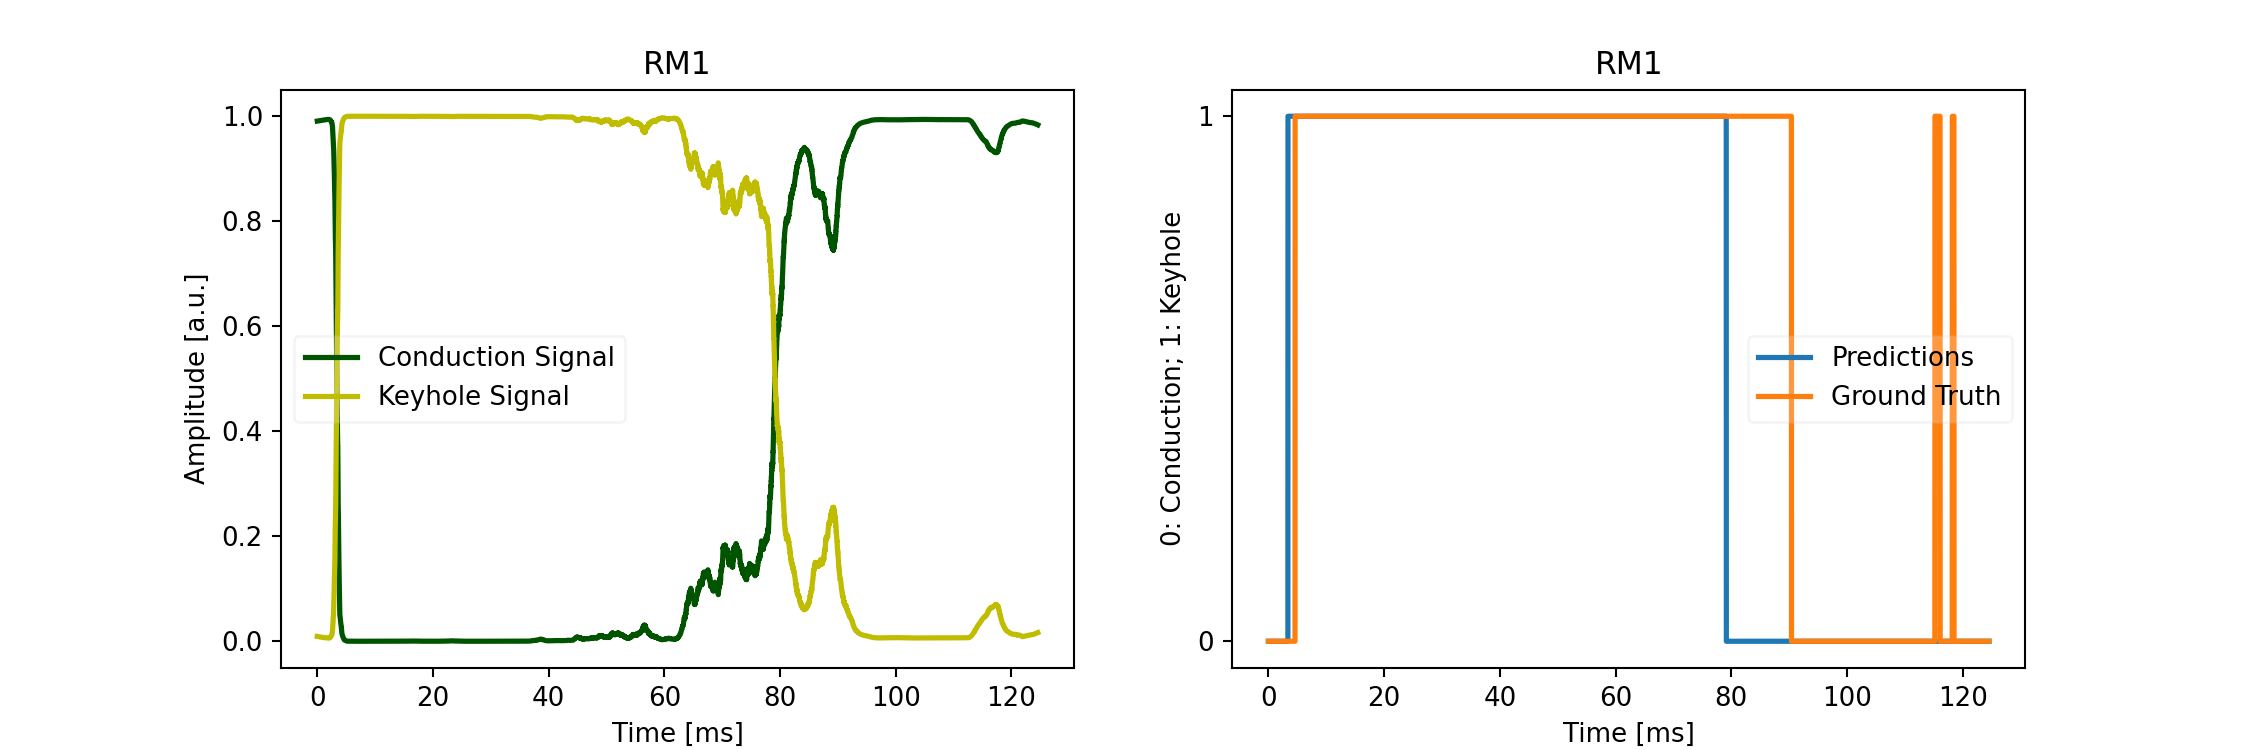

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


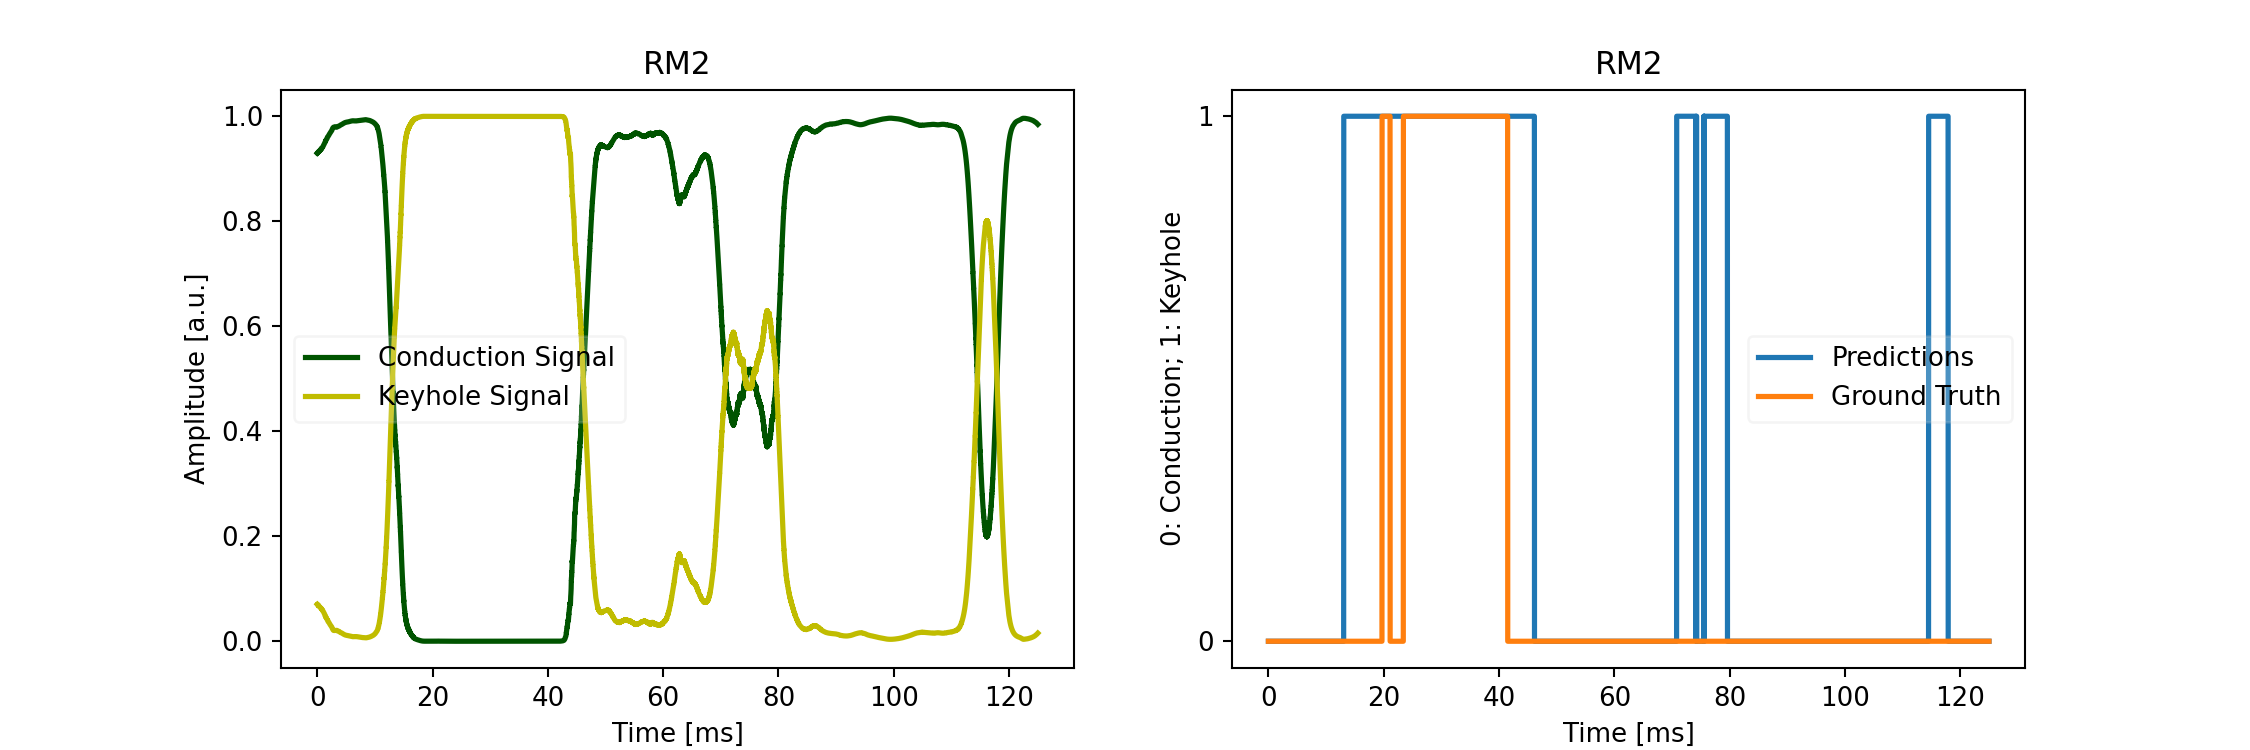

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


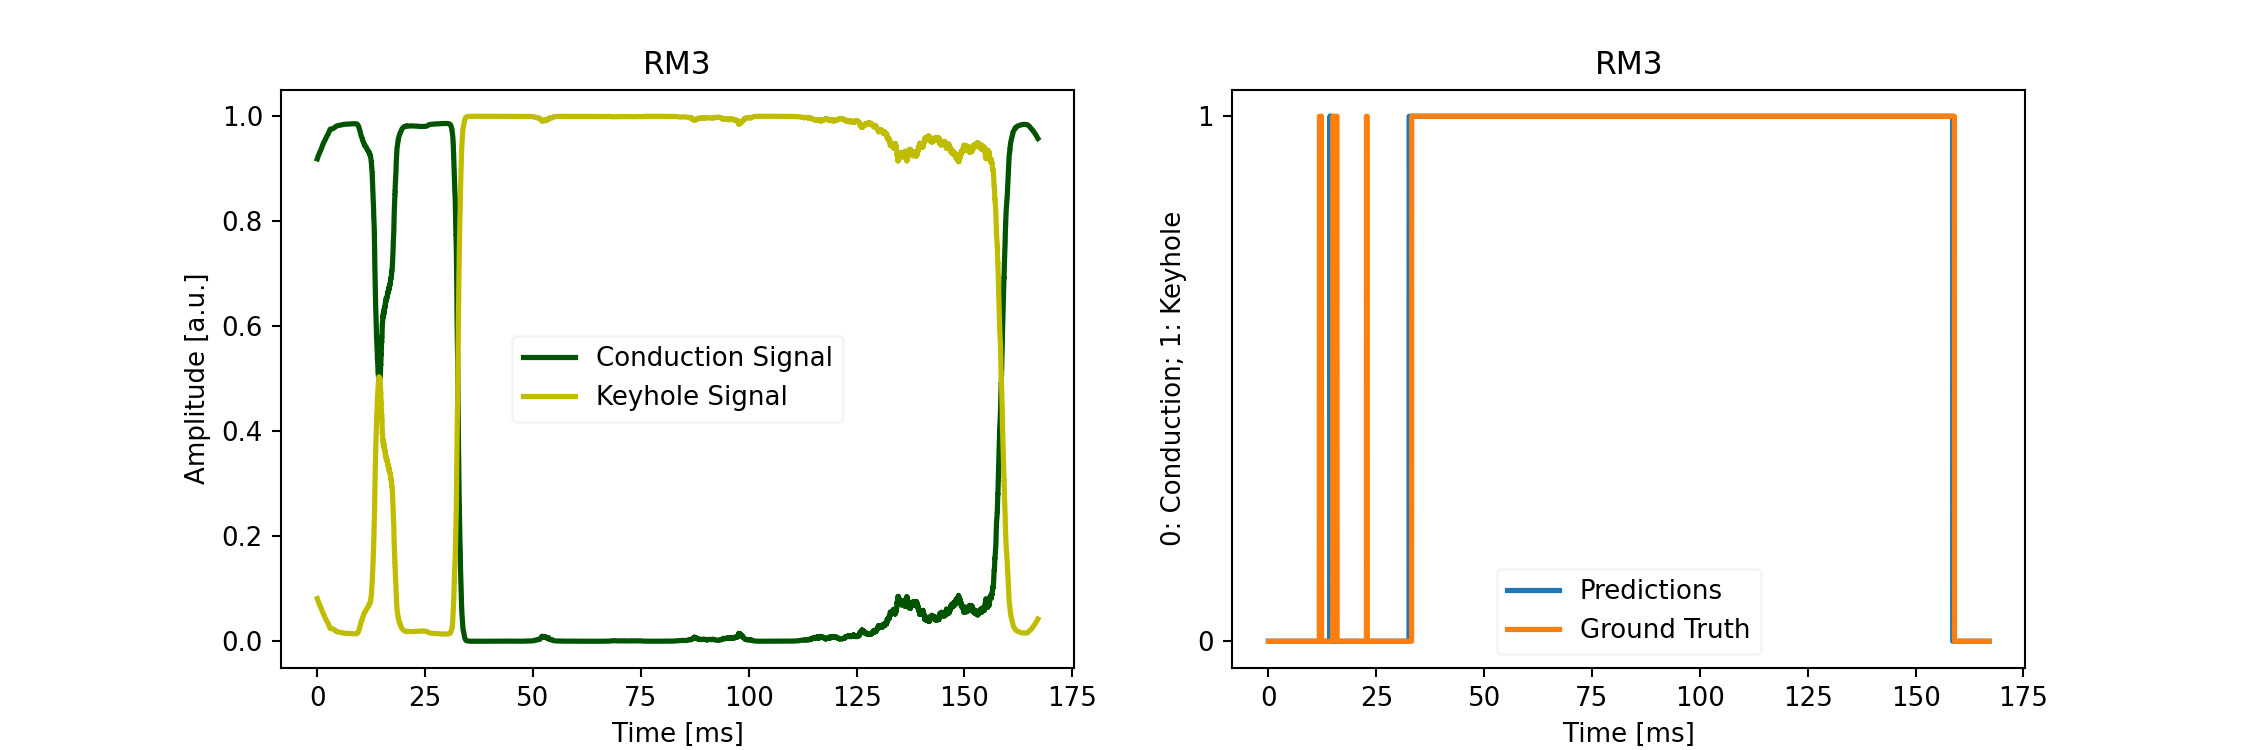

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


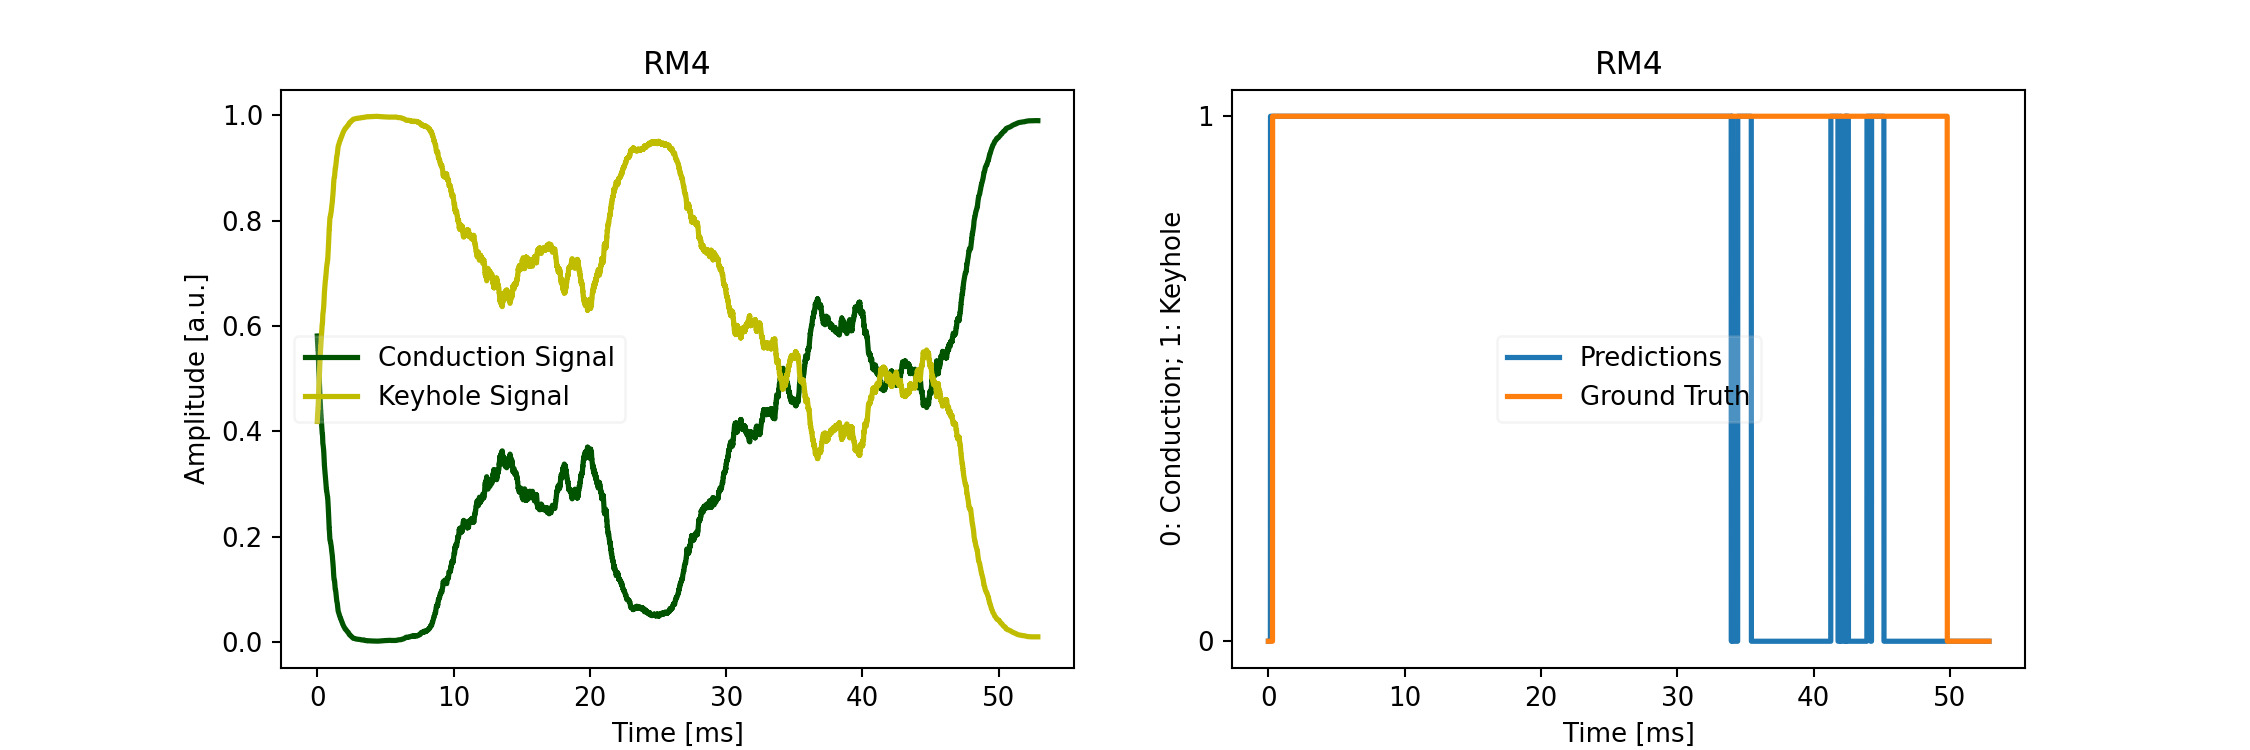

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


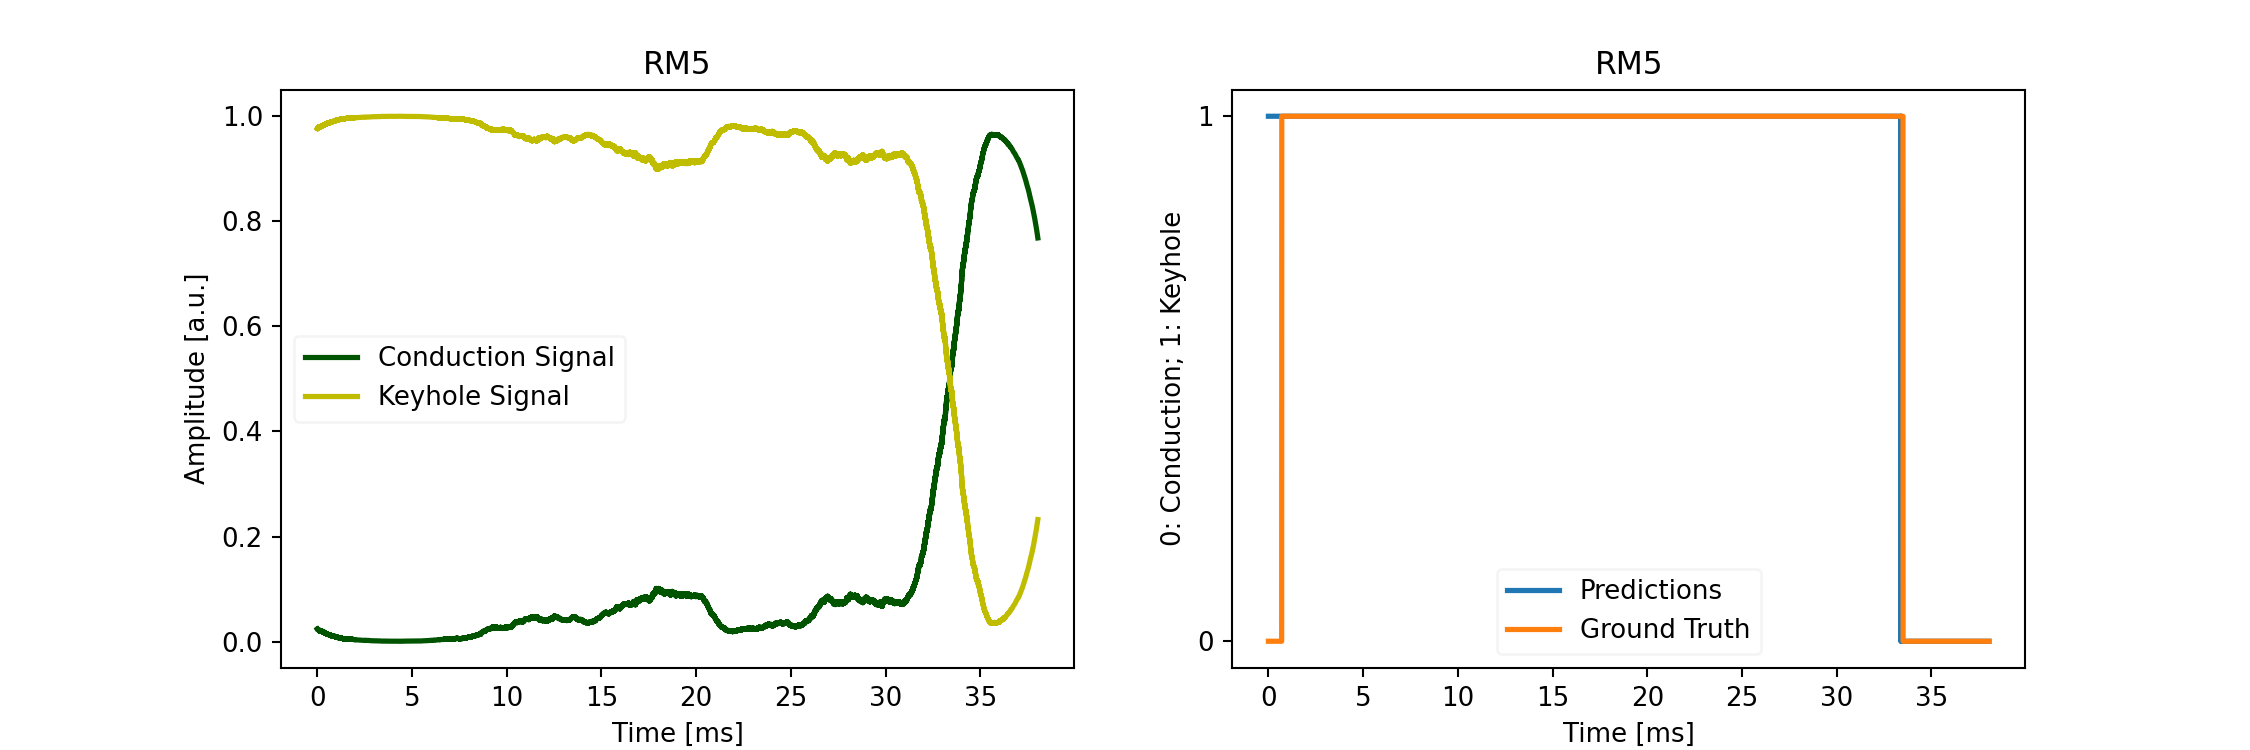

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


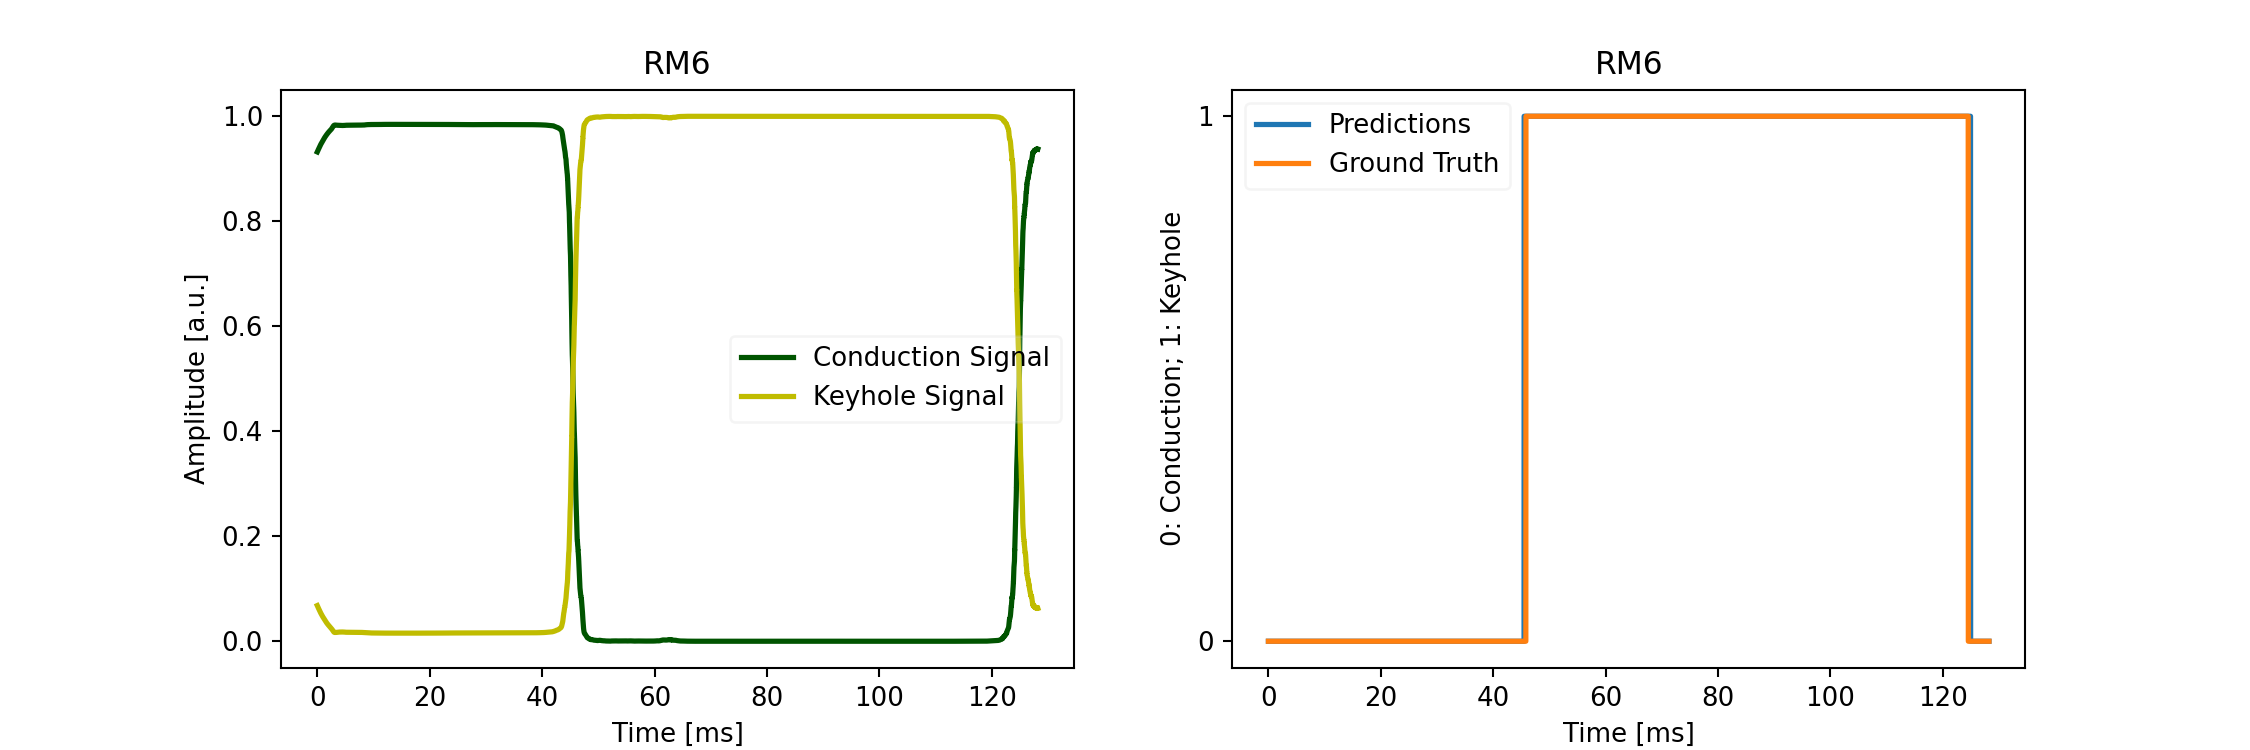

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


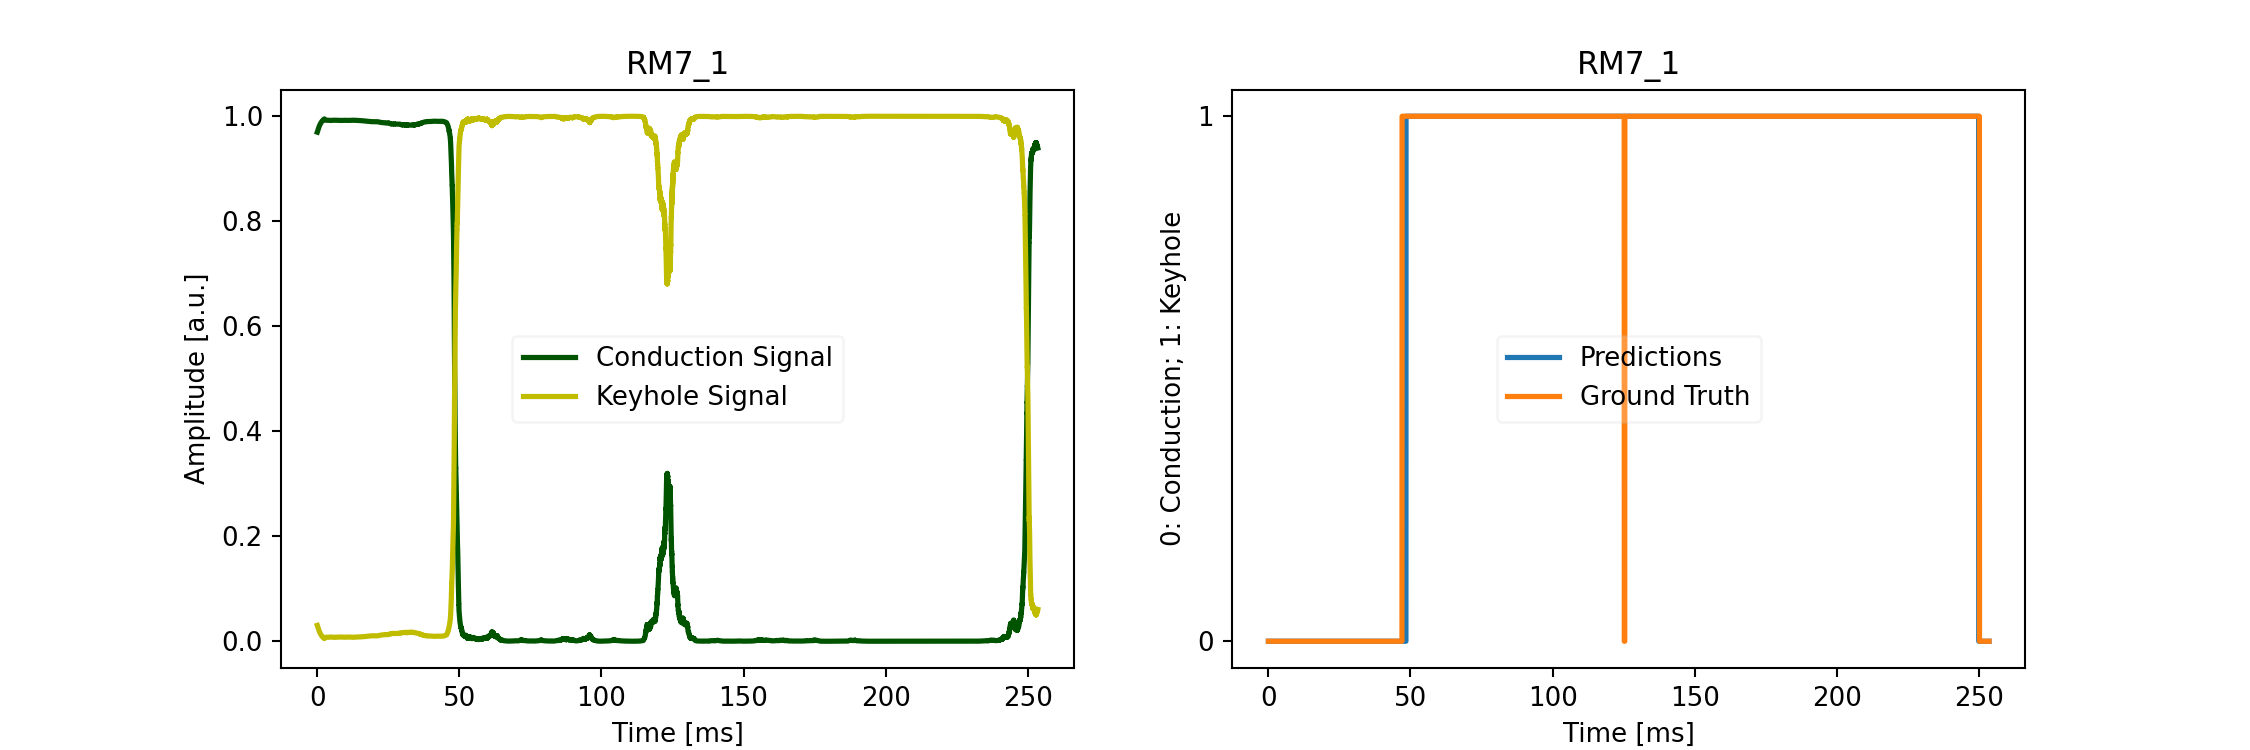

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


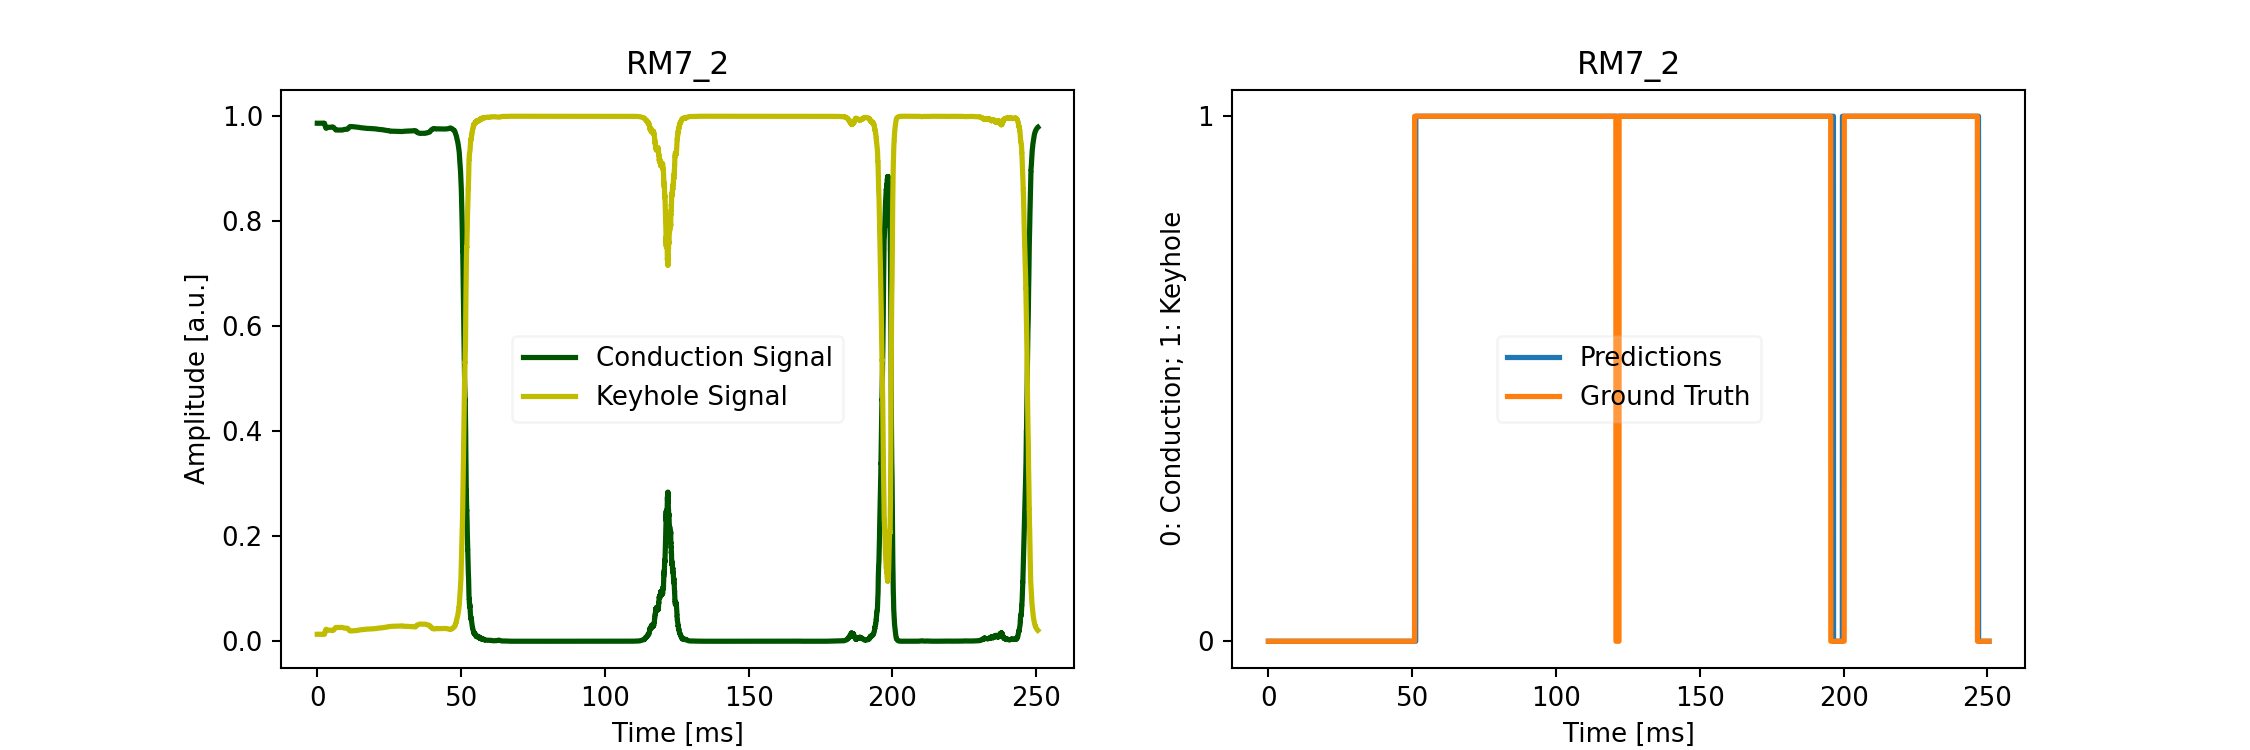

----------------------------------------------------------------------------------------------------


<IPython.core.display.Javascript object>


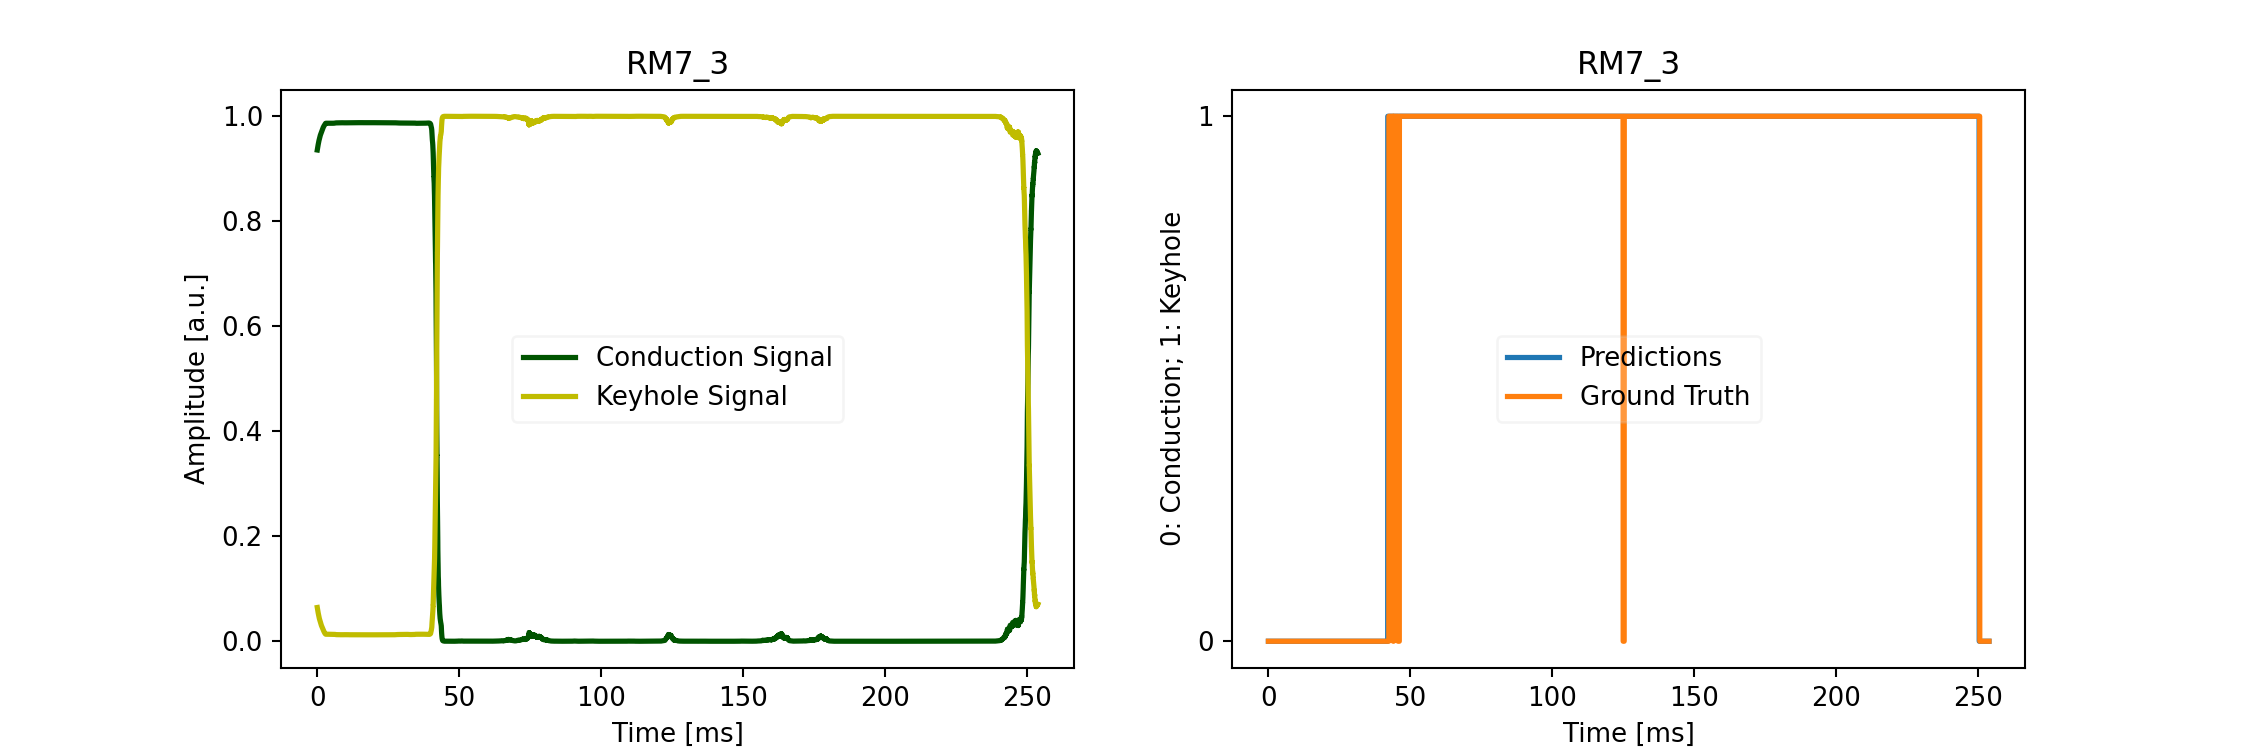

----------------------------------------------------------------------------------------------------


In [20]:
m = nn.Softmax(dim=1)
precision_calc = Precision(task='Multiclass', average='none', num_classes=2)
recall_calc = Recall(task='Multiclass', average='none', num_classes=2)

def process_signal(i, outer, names, GTs, xs, models_Cond, models_KH, device, Fs):
    with torch.no_grad():
        name = names[outer]
        GT = GTs[outer].to(device)
        signal = xs[outer].to(device)
        
        time = np.linspace(start=0, stop=len(signal) * 1/Fs, num=len(signal)) * 1000
        prediction = models_Cond[i]
        predictionKH = models_KH[i]
        
        x_Cond = prediction(signal)
        x_KH = predictionKH(signal)

        myPreds = torch.cat([x_Cond, x_KH], 1)
        output = m(myPreds)
        _, ind = torch.max(myPreds, 1)

        visualize_signal(time, output, ind, GT, name)
        
        score = F1(ind.long(), GT.view(-1).long()).cpu().detach().numpy()
        precision = precision_calc(ind.long().cpu(), GT.view(-1).long().cpu()).cpu().detach().numpy()
        recall = recall_calc(ind.long().cpu(), GT.view(-1).long().cpu()).cpu().detach().numpy()

        return name, score, precision, recall, GT.view(-1).long(), ind.long()

def visualize_signal(time, output, ind, GT, name):
    fig, axs = plt.subplots(1, 2)
    axs[0].plot(time, output[:, 0].cpu(), label='Conduction Signal', linewidth=2, color=(0, 84/255, 0))
    axs[0].plot(time, output[:, 1].cpu(), label='Keyhole Signal', linewidth=2, color=(192/255, 188/255, 0))
    axs[1].plot(time, ind.cpu(), label='Predictions', linewidth=2)
    axs[1].plot(time, GT.cpu(), label='Ground Truth', linewidth=2)
    
    for ax, title in zip(axs, [name, name]):
        ax.set_title(title)
        ax.set_xlabel('Time [ms]')
        ax.legend(framealpha=0.2)
    axs[0].set_ylabel('Amplitude [a.u.]')
    axs[1].set_ylabel('0: Conduction; 1: Keyhole')
    axs[1].set_yticks([0, 1])
    fig.set_size_inches(12, 4)
    plt.show()

overall_results = []
overall_preds = []
overall_GTs = []

for i, outer in enumerate(range(len(names))):
    name, scores, precisions, recalls, GT, preds = process_signal(i, outer, names, GTs, xs, models_Cond, models_KH, device, Fs)
    
    signal_metrics = {
        'Signal Name': name,
        'F1 Conduction': scores[0],
        'F1 Keyhole': scores[1],
        'Precision Conduction': precisions[0],
        'Precision Keyhole': precisions[1],
        'Recall Conduction': recalls[0],
        'Recall Keyhole': recalls[1]
    }
    overall_preds.append(preds)
    overall_GTs.append(GT)

    # Print metrics for the current signal
    df_signal = pd.DataFrame([signal_metrics])
    display(df_signal.style.hide(axis='index'))
    print('-' * 100)

# Overall F1 score, precision, and recall across all signals
overall_score = F1(torch.cat(overall_preds), torch.cat(overall_GTs)).cpu().detach().numpy()
overall_prec = precision_calc(torch.cat(overall_preds).cpu(), torch.cat(overall_GTs).cpu()).cpu().detach().numpy()
overall_rec = recall_calc(torch.cat(overall_preds).cpu(), torch.cat(overall_GTs).cpu()).cpu().detach().numpy()

for j, regime in enumerate(['Conduction', 'Keyhole']):
    overall_results.append({
        'Regime': regime,
        'Overall F1-score': overall_score[j],
        'Overall Precision': overall_prec[j],
        'Overall Recall': overall_rec[j]
    })

# Display the overall results table
df_overall = pd.DataFrame(overall_results)

### Overall Performance Metrics Display
In this section, we display a summarized table presenting the overall performance metrics — specifically, the F1-score, Precision, and Recall — for both the Conduction and Keyhole regimes. The table showcases how the trained model performed across all signals in the dataset.

In [21]:
display(df_overall.style.hide(axis='index'))

### Filter Visualization: Impulse and Frequency Responses
This section visualizes the impulse and frequency responses of the Conduction and Keyhole Filters. By comparing these filters against their initial configurations, one can understand how they have been optimized after training.

<IPython.core.display.Javascript object>


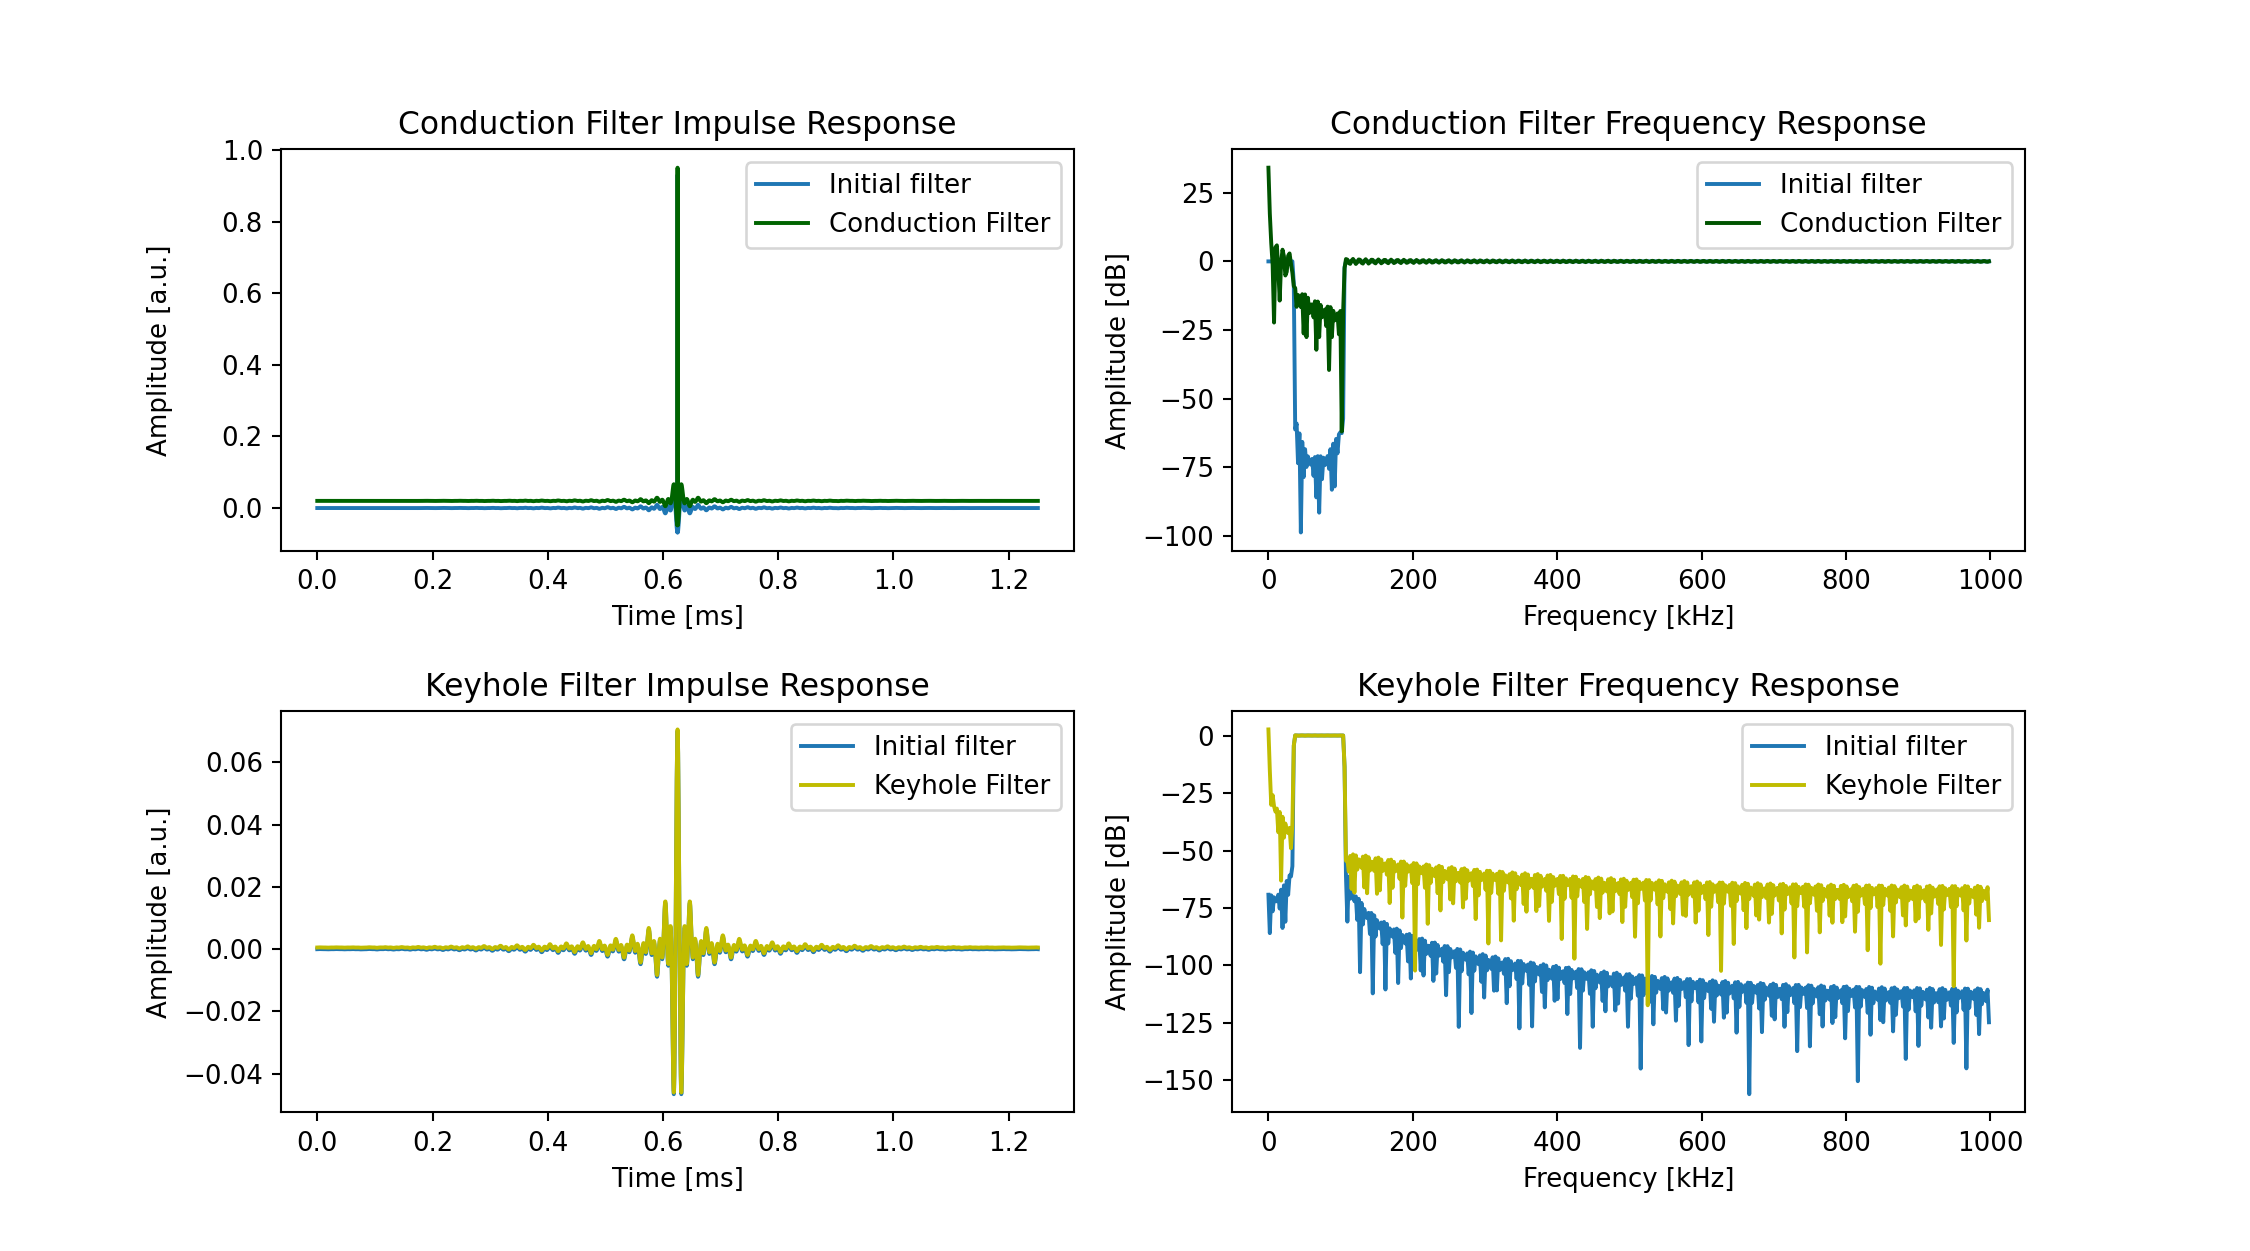

In [22]:
time = np.linspace(start=0,stop=len(weigths_init[:])*1/Fs,num=len(weigths_init[:]))*1000

# Extract weights of the Conduction filter from the trained model
weights_starCond = (prediction.smooth_filtKH.weight.view(-1).cpu().detach().numpy() 
                    + prediction.smooth_filtKH.bias.view(-1).cpu().detach().numpy())

# Set up a 2x2 subplot for impulse and frequency responses of both filters
fig, axs = plt.subplots(2, 2)

# Plot the impulse response of the Conduction filter
axs[0,0].plot(time, weigths_init_cond[:], label='Initial filter')
axs[0,0].plot(time, weights_starCond, label='Conduction Filter', color='darkgreen')
axs[0,0].set_title('Conduction Filter Impulse Response')
axs[0,0].set_xlabel('Time [ms]')
axs[0,0].set_ylabel('Amplitude [a.u.]')
axs[0,0].legend()

# Compute and plot the frequency response of the Conduction filter
w, h = scipy.signal.freqz(weigths_init_cond[:], fs=Fs)
w_Cond, h_Cond = scipy.signal.freqz(weights_starCond, fs=Fs)
axs[0,1].plot(w/1e3, 20 * np.log10(abs(h)), label='Initial filter')
axs[0,1].plot(w_Cond/1e3, 20 * np.log10(abs(h_Cond)), label='Conduction Filter', color=(0, 84/255, 0))
axs[0,1].set_title('Conduction Filter Frequency Response')
axs[0,1].set_xlabel('Frequency [kHz]')
axs[0,1].set_ylabel('Amplitude [dB]')
axs[0,1].legend()

# Extract weights of the Keyhole filter from the trained model
weights_starKH = (predictionKH.smooth_filtKH.weight.view(-1).cpu().detach().numpy() 
                  + predictionKH.smooth_filtKH.bias.view(-1).cpu().detach().numpy())

# Plot the impulse response of the Keyhole filter
axs[1,0].plot(time, weigths_init[:], label='Initial filter')
axs[1,0].plot(time, weights_starKH, label='Keyhole Filter', color=(192/255, 188/255, 0))
axs[1,0].set_title('Keyhole Filter Impulse Response')
axs[1,0].set_xlabel('Time [ms]')
axs[1,0].set_ylabel('Amplitude [a.u.]')
axs[1,0].legend()

# Compute and plot the frequency response of the Keyhole filter
w, h = scipy.signal.freqz(weigths_init[:], fs=Fs)
w_KH, h_KH = scipy.signal.freqz(weights_starKH, fs=Fs)
axs[1,1].plot(w/1e3, 20 * np.log10(abs(h)), label='Initial filter')
axs[1,1].plot(w_KH/1e3, 20 * np.log10(abs(h_KH)), label='Keyhole Filter', color=(192/255, 188/255, 0))
axs[1,1].set_title('Keyhole Filter Frequency Response')
axs[1,1].set_xlabel('Frequency [kHz]')
axs[1,1].set_ylabel('Amplitude [dB]')
axs[1,1].legend()

# Adjusting the layout and saving the figure
fig.subplots_adjust(hspace=0.4)
fig.set_size_inches(12, 6.67)  # 10/3*2 = 6.67
fig.align_ylabels(axs[:, 0])


### Confusion Matrix Visualization 

In this section, we visualize the confusion matrix for our segmentation predictions in terms of percentages. This normalized representation provides a clearer insight into the model's performance relative to the number of instances for each class. It indicates the percentage of times each class was correctly predicted and the percentage of times misclassifications occurred.


<IPython.core.display.Javascript object>


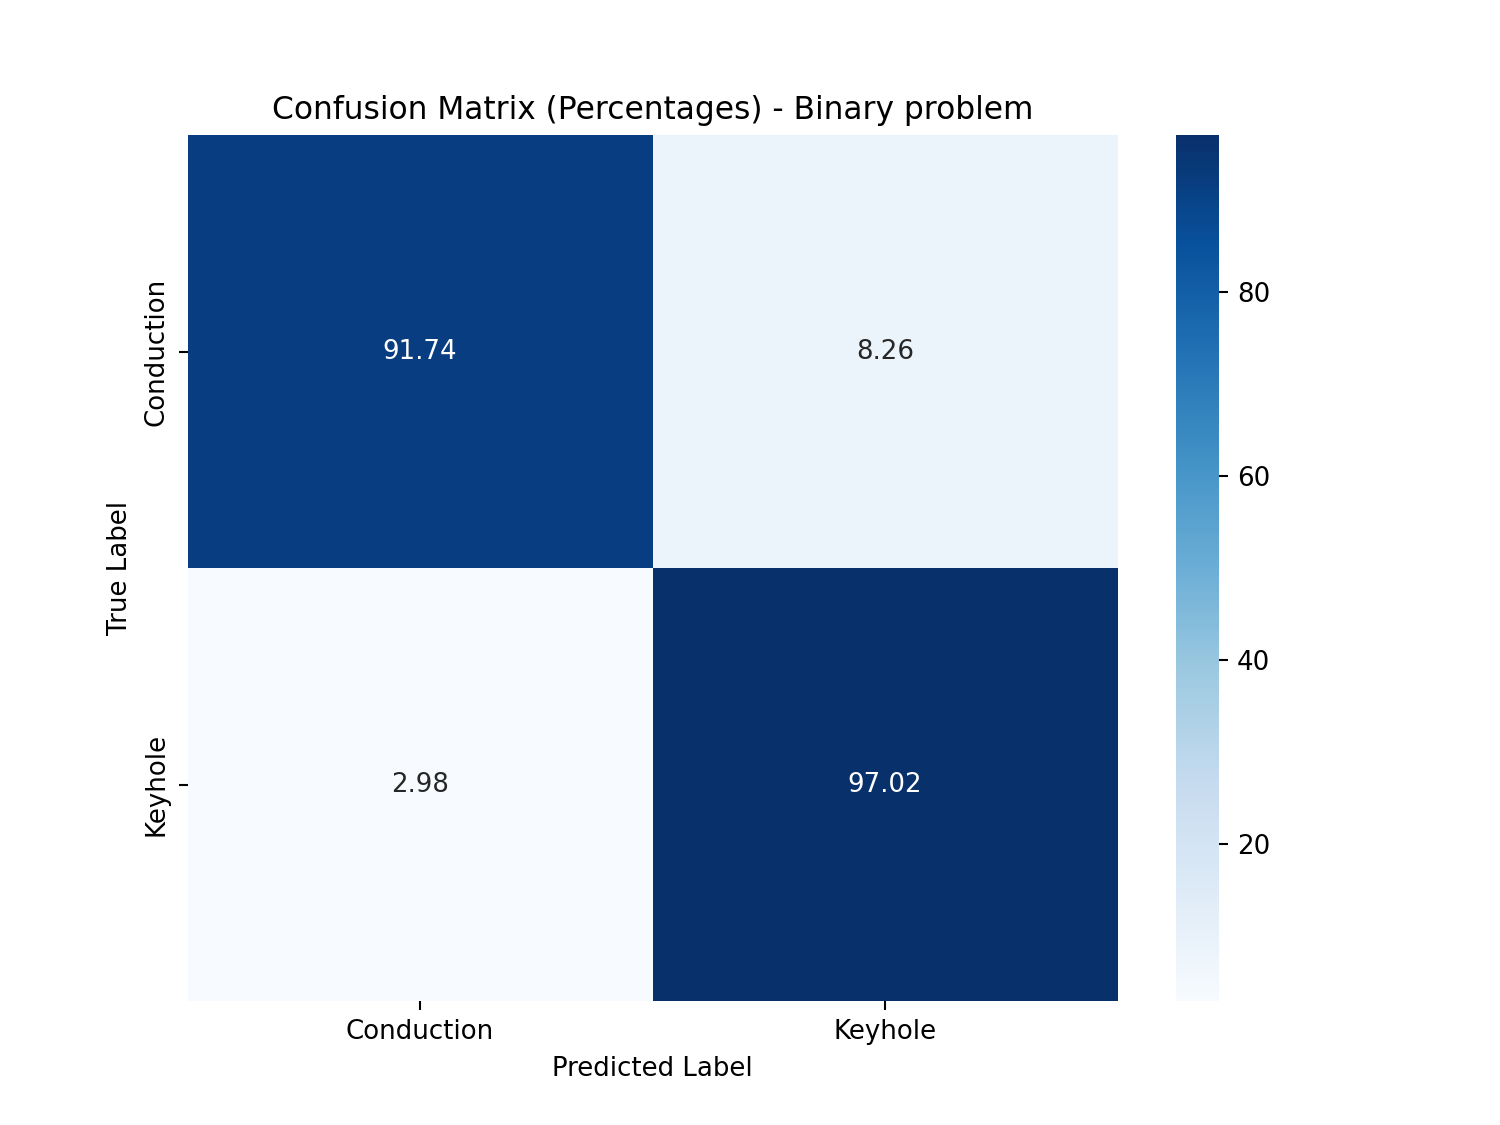

In [23]:
# Calculate the confusion matrix
cm = confusion_matrix(torch.cat(overall_GTs).cpu(), torch.cat(overall_preds).cpu())

# Normalize the confusion matrix to show percentages
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=True, fmt=".2f", cmap='Blues', xticklabels=['Conduction', 'Keyhole'], yticklabels=['Conduction', 'Keyhole'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix (Percentages) - Binary problem')
plt.show()

---
**Disclaimer and Credits**

**Disclaimer**: This code is shared to promote transparency and further research. While every effort has been exerted to ensure its accuracy, we provide it "as-is" without warranties. Users are advised to utilize, adapt, and modify the code at their discretion and risk. The authors disclaim any liability arising from its use, including, but not limited to, errors or unintended outcomes.

**Credits**: The conceptualization and execution of this code are credited to Giulio Masinelli. Released under the CC0 license in accordance with Nature Communication's recommendations. Refer to the paper, "Harmonizing Sound and Light: X-Ray Imaging Unveils Acoustic Signatures of Stochastic Inter-Regime Instabilities during Laser Melting," for a comprehensive understanding.

**Contact**: For queries, further details, or opportunities related to this research segment, please connect with Giulio Masinelli at [giulio.masinelli@empa.ch](mailto:giulio.masinelli@empa.ch).

---